In [1]:
from Bio.PDB import *
import numpy as np
import pandas as pd
import nglview as nv
import matplotlib.pyplot as plt
import pynmrstar
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from glob import glob
import os

# Idea

This analysis aims to find out the residue-type correlation between H-bond length (*actually, N---O distance*) and this amide's (HN and N) chemical shifts in the beta-sheet structures. We want to explain the diagonal tilts in hNH spectra of amyloids.

~~PIQCed PACSY is used as the source of chemical shifts and STRIDE class. (*alternatively: filter not by class but by angle???*)~~ PACSY is too small and inferior to the ReBoxitory data!

`biopython` package used to fetch and analyse PDB structures. 

## Algorithm
* For all PDBs:
    * run DSSP and identify sheets and strands (first chains only??..)
    * Find the matching BMRB file and take the shift data
    * List all amide nitrogens of the given residues
    * List all oxygens in the chain
    * Find pairs within 4 Angstrom radius

# 1. Reading DSSP tables and the corresponding BMRB assignments

## 1.1 Loading tables

In [2]:
wdir='~/sciebo/PDB analysis/'
dsspdir='C:/Users/Krairy/OneDrive/PhD/dssp/'

In [4]:
rel=pd.read_csv(wdir+'/PDB_BMRB_pairs.csv', index_col=0, sep=';')
rel=rel[~rel.index.duplicated(keep='first')].sort_index()

In [97]:
#rel.loc[5625][0]
rel

bmrb_id
pdb_id         
1A2I       5625
1A3P       4201
1A5J       4114
1AXH       5702
1AYG       5086
...         ...
7L53      30828
7L54      30829
7L55      30830
7L7A      30833
8TFV       4387

[6353 rows x 1 columns]

In [5]:
res_names = pd.read_csv("C:/Users/Krairy/OneDrive/PhD/H-bonds/rc_shifts.tab", sep='\t')
res_names.RES = res_names.RES.apply(lambda s: s.upper())
res_names = res_names.set_index('RES')['ID']
res_names

RES
ALA    A
CYS    C
ASP    D
GLU    E
PHE    F
GLY    G
HIS    H
ILE    I
LYS    K
LEU    L
MET    M
ASN    N
PRO    P
GLN    Q
ARG    R
SER    S
THR    T
VAL    V
TRP    W
TYR    Y
Name: ID, dtype: object

In [6]:
csv_dir = 'C:\\Users\\Krairy\\OneDrive\\PhD\\H-bonds\\DSSP_CSVs\\'

In [7]:
dssp_cols = "CHAIN AA SS ASA PHI PSI # NH-O1_idx NH-O1_En O-NH1_idx O-NH1_En NH-O2_idx NH-O2_En O-NH2_idx O-NH2_En".split()
## Note the order! The 5the col in the dictionary will be the res num. See Bio.PDB documentation (but double-check)

## 1.2 Combining the data
The following code executes about 40 minutes!

In [204]:
## Takes about 40 minutes!!

fnames=list(glob(dsspdir+'*.dssp'))

seq_df = pd.DataFrame()
for fname in fnames:
    basename = os.path.basename(fname)
    pdb_id = basename.split('.')[0]
    bmrb_id = rel.loc[pdb_id.upper()][0]
    
    # Loading data
    
    ## DSSP
    dssp = make_dssp_dict(f"C:\\Users\\Krairy\\OneDrive\\PhD\\dssp\\{pdb_id}.dssp")
    dssp_df = pd.DataFrame.from_dict(dssp[0]).T
    dssp_df.reset_index(inplace=True)
    dssp_df.drop('level_1', axis=1, inplace=True)
    dssp_df.columns = dssp_cols
    dssp_df=dssp_df.loc[dssp_df.CHAIN == dssp_df.CHAIN.unique()[0]] # only the first chain!
    
    ## BMRB
    nmrstar = pynmrstar.Entry.from_database(bmrb_id)
    loops = nmrstar.get_saveframes_by_category('assigned_chemical_shifts')[0]
    shifts = loops['_Atom_chem_shift']
    data = StringIO(shifts.get_data_as_csv().replace("_Atom_chem_shift.", ""))
    df_bmrb = pd.read_csv(data, index_col=0)
    df_bmrb = df_bmrb.query('Atom_ID == "H" or Atom_ID == "N" or Atom_ID == "CA" or Atom_ID == "CB"')
    
    ## Assembley
    df_ = pd.DataFrame()
    df_ = dssp_df['CHAIN # AA SS PHI PSI NH-O1_idx NH-O1_En O-NH1_idx O-NH1_En NH-O2_idx NH-O2_En O-NH2_idx O-NH2_En'.split()]
    df_ = pd.merge(df_, df_bmrb['Seq_ID Comp_ID Atom_ID Val'.split()], 
                           left_on='#', right_on='Seq_ID' , how='outer') ## Here the magic happens!!
    
    ## Check for sequence match!!
    ### renaming cysteins (up to 4 CC bridges)
    if 'a' in df_.AA.unique():
        df_.loc['a' ,'AA'] = 'C'
    if 'b' in df_.AA.unique():
        df_.loc['b' ,'AA'] = 'C'
    if 'c' in df_.AA.unique():
        df_.loc['c' ,'AA'] = 'C'
    if 'd' in df_.AA.unique():
        df_.loc['d' ,'AA'] = 'C'
                    
    seq_df = df_[['AA', 'Comp_ID']]

    try:
        seq_df['AA_BMRB'] = df_['Comp_ID'].dropna().apply(lambda aa: res_names.loc[aa]) # to short format
    except KeyError: ## in case of non-standard amino acids
        continue ## skip the entry altogether
        
    seq_df = seq_df.dropna()
    
    if len(seq_df[['AA', 'AA_BMRB']].drop_duplicates(keep=False))==0:
        print('OK!')
        df_['BMRB_ID'] = bmrb_id
        df_['PDB_ID'] = pdb_id
        df_ = df_.query('SS == "E" or SS == "B"') # for the current research we need only Extended structures 
        # (and also we might need to save space on the drive)

        ## Writing to the disk to have a checkpoint
        df_.to_csv(csv_dir+f'/{pdb_id}_{bmrb_id}.csv')
    else:
        print('Too bad!')
        print(pdb_id, bmrb_id)

C:\Users\Krairy\AppData\Local\Temp\ipykernel_7804\170302657.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq_df['AA_BMRB'] = df_['Comp_ID'].dropna().apply(lambda aa: res_names.loc[aa]) # to short format


OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1cr8 4475
OK!
OK!
Too bad!
1d1o 4581
OK!
OK!
OK!
OK!
Too bad!
1d7q 4519
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1e52 4622
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1f2h 4636
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1gh9 4740
OK!
OK!
OK!
OK!
OK!
Too bad!
1h3z 5538
OK!
OK!
OK!
OK!
Too bad!
1hbw 5180
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1idh 5025
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1je9 5052
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1jjd 5147
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
1jwe 5122
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!


OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2k5w 15850
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2k6m 15873
Too bad!
2k6n 15874
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2k7z 15932
Too bad!
2k85 15938
OK!
OK!
OK!
Too bad!
2k8d 15941
OK!
Too bad!
2k8f 15944
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2k9u 16002
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2kcn 16087
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2kdd 16110
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2ke1 16510
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2kff 16179
Too bad!
2kfg 16180
Too bad!
2kfh 16181
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2kg4 15855
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2khx 16256
Too bad!
2khz 16258
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!


OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mkn 17679
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mlk 18200
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mn2 19876
OK!
OK!
OK!
Too bad!
2mnh 19892
OK!
OK!
OK!
OK!
OK!
Too bad!
2mnz 19914
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mp2 19961
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mpf 19977
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mpt 25000
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mqa 25024
OK!
OK!
Too bad!
2mqd 25028
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mr8 25065
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2ms4 25104
OK!
OK!
OK!
Too bad!
2msr 25130
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
2mt5 25149
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!


OK!
OK!
OK!
OK!
Too bad!
6gsf 34286
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6gwx 34295
OK!
OK!
OK!
OK!
Too bad!
6h8c 34307
OK!
Too bad!
6hh0 34309
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6ijq 36133
OK!
OK!
OK!
OK!
Too bad!
6lag 36299
OK!
OK!
Too bad!
6mcf 30511
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6msp 30527
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6nan 27051
OK!
Too bad!
6ne8 30551
Too bad!
6nfw 27506
OK!
Too bad!
6nhy 30554
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6ns8 30494
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6o7g 30585
Too bad!
6ob1 30590
OK!
Too bad!
6obw 30593
OK!
OK!
OK!
OK!
Too bad!
6oky 30600
OK!
OK!
OK!
OK!
OK!
Too bad!
6osw 30608
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6ppc 30626
OK!
OK!
OK!
OK!
OK!
Too bad!
6pri 30634
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6q2z 34334
OK!
Too bad!
6q5z 34335
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Too bad!
6qh2 34352
OK!
OK!
OK!
OK!
OK!
Too bad!
6qtc 34362
OK!
OK!
OK!


### Troubleshooting

Find the files with problems

In [205]:
def id_from_path(path):
    pdb_id = os.path.basename(path)
    pdb_id = pdb_id.split('.')[0].split('_')[0]
    return pdb_id

processed_IDs = [id_from_path(path) for path in list(glob(csv_dir+'/*.csv'))]
all_IDs = [id_from_path(path) for path in list(glob(dsspdir+'*.dssp'))]

PDBs_with_problems = set(all_IDs) - set(processed_IDs)
print(str(len(PDBs_with_problems))+" files had issues ("+str(len(PDBs_with_problems)/len(all_IDs)*100 )+ " %)")
print(str(len(all_IDs))+" structures in total")
PDBs_with_problems

575 files had issues (10.996366418053166 %)
5229 structures in total


{'1ee7',
 '1f2h',
 '1gh9',
 '1h3z',
 '1hbw',
 '1idh',
 '1ih9',
 '1je9',
 '1jjd',
 '1jwe',
 '1k09',
 '1k76',
 '1ka7',
 '1kfz',
 '1kgm',
 '1kn6',
 '1m4p',
 '1m4q',
 '1no8',
 '1nwb',
 '1nxn',
 '1nyn',
 '1oo9',
 '1osl',
 '1pxe',
 '1r05',
 '1r9k',
 '1rl1',
 '1rxr',
 '1s6l',
 '1s7e',
 '1so9',
 '1sp0',
 '1ssf',
 '1uvf',
 '1vj6',
 '1w1f',
 '1wa7',
 '1wh4',
 '1y4e',
 '1yel',
 '1z5f',
 '1z66',
 '1z8r',
 '1zac',
 '1zg2',
 '2a2b',
 '2a3s',
 '2aby',
 '2ami',
 '2bai',
 '2bug',
 '2c34',
 '2cef',
 '2ceh',
 '2cez',
 '2cfj',
 '2d2w',
 '2ddy',
 '2dii',
 '2fgx',
 '2fk4',
 '2fyj',
 '2g0k',
 '2g0l',
 '2g46',
 '2gg1',
 '2gjf',
 '2gov',
 '2h7d',
 '2h7e',
 '2hdl',
 '2hga',
 '2hgc',
 '2i94',
 '2i9y',
 '2ife',
 '2jgw',
 '2jgx',
 '2jm0',
 '2jmx',
 '2jn0',
 '2jng',
 '2jo0',
 '2jo9',
 '2joa',
 '2joh',
 '2jop',
 '2jpe',
 '2jqf',
 '2jrb',
 '2jt8',
 '2jvo',
 '2jw1',
 '2jx2',
 '2jzc',
 '2k17',
 '2k3b',
 '2k3m',
 '2k3u',
 '2k4b',
 '2k4j',
 '2k5w',
 '2k6m',
 '2k6n',
 '2k7z',
 '2k85',
 '2k8d',
 '2k8f',
 '2k9e',
 '2k9u',
 

## 1.4 Assembling into one dataset

In [206]:
df = pd.DataFrame() # the ultimate table
fnames=list(glob(csv_dir+'/*.csv'))

for fname in fnames:
    df_ = pd.read_csv(fname)
    if df_.empty:
        continue
    df = pd.concat((df, df_))

df   

Unnamed: 0 CHAIN   # AA SS    PHI    PSI  NH-O1_idx  NH-O1_En  O-NH1_idx  \
0           10     A   5  I  B  -79.4  123.6       11.0      -2.1         13   
1           11     A   5  I  B  -79.4  123.6       11.0      -2.1         13   
2           12     A   5  I  B  -79.4  123.6       11.0      -2.1         13   
3           13     A   5  I  B  -79.4  123.6       11.0      -2.1         13   
4           27     A  10  P  B  -75.7  128.2        0.0       0.0         25   
..         ...   ...  .. .. ..    ...    ...        ...       ...        ...   
42          73     A  25  b  E -110.5  146.7       -2.0      -0.4        -11   
43          74     A  26  F  E -131.3   95.1      -13.0      -2.7        -14   
44          75     A  26  F  E -131.3   95.1      -13.0      -2.7        -14   
45          76     A  26  F  E -131.3   95.1      -13.0      -2.7        -14   
46          77     A  26  F  E -131.3   95.1      -13.0      -2.7        -14   

    ...  NH-O2_idx  NH-O2_En  O-NH2_idx  O-NH2_En  Seq_ID  Comp_ID Atom_ID  \
0   ...         -3      -0.1         14      -0.4     5.0      ILE       N   
1   ...         -3      -0.1         14      -0.4     5.0      ILE       H   
2   ...         -3      -0.1         14      -0.4     5.0      ILE      CA   
3   ...         -3      -0.1         14      -0.4     5.0      ILE      CB   
4   ...          0       0.0         -1      -0.1    10.0      PRO      CA   
..  ...        ...       ...        ...       ...     ...      ...     ...   
42  ...        -11      -0.3          3      -0.1    25.0      CYS       N   
43  ...         -2      -0.4        -13      -0.6    26.0      PHE       H   
44  ...         -2      -0.4        -13      -0.6    26.0      PHE      CA   
45  ...         -2      -0.4        -13      -0.6    26.0      PHE      CB   
46  ...         -2      -0.4        -13      -0.6    26.0      PHE       N   

        Val  BMRB_ID  PDB_ID  
0   122.800     5702    1axh  
1     9.190     5702    1axh  
2    60.100     5702    1axh  
3    40.200     5702    1axh  
4    63.100     5702    1axh  
..      ...      ...     ...  
42  117.007    30828    7l53  
43    8.442    30828    7l53  
44   55.194    30828    7l53  
45   39.101    30828    7l53  
46  118.525    30828    7l53  

[352763 rows x 21 columns]

In [207]:
df.to_csv(wdir+'/shifts_H-bonds.tab', sep='\t')

In [208]:
df.PDB_ID.unique().shape # How many structures without issues and with beta-sheets / strands we have

(3488,)

# 2. Measuring the H-bonds

In [8]:
df = pd.read_csv(wdir+'/shifts_H-bonds.tab', sep='\t')
df.loc[:, ["NH-O1_idx", "NH-O2_idx", "O-NH1_idx", "O-NH2_idx"]].fillna(0, inplace=True)

In [194]:
fnames=list(glob(csv_dir+'/*.csv'))

for fname in fnames[:3]:
    basename = os.path.basename(fname)
    basename = basename.split('.')[0].split('_')
    pdb_id, bmrb_id = basename
    print(pdb_id, bmrb_id)

1a5j 4114
1axh 5702
1azp 5905


In [252]:
pdbl.retrieve_pdb_file(pdb_id.upper(), pdir=pdbdir)
structure = parser.get_structure("protein", pdbdir+pdb_id+".cif")
try:
    chain = structure[0]["A"]
except KeyError:
    problems.append(pdb_id)
        
chain[int(5)]['N'] - chain[5+11]['O']

Structure exists: 'D://Structures/1axh.cif' 


3.182717

In [362]:
df

Unnamed: 0  Unnamed: 0.1 CHAIN   # AA SS    PHI    PSI  NH-O1_idx  \
0                0            10     A   5  I  B  -79.4  123.6       11.0   
1                1            11     A   5  I  B  -79.4  123.6       11.0   
2                2            12     A   5  I  B  -79.4  123.6       11.0   
3                3            13     A   5  I  B  -79.4  123.6       11.0   
4                4            27     A  10  P  B  -75.7  128.2        0.0   
...            ...           ...   ...  .. .. ..    ...    ...        ...   
352758          42            73     A  25  b  E -110.5  146.7       -2.0   
352759          43            74     A  26  F  E -131.3   95.1      -13.0   
352760          44            75     A  26  F  E -131.3   95.1      -13.0   
352761          45            76     A  26  F  E -131.3   95.1      -13.0   
352762          46            77     A  26  F  E -131.3   95.1      -13.0   

        NH-O1_En  ...  NH-O2_idx  NH-O2_En  O-NH2_idx  O-NH2_En  Seq_ID  \
0           -2.1  ...         -3      -0.1         14      -0.4     5.0   
1           -2.1  ...         -3      -0.1         14      -0.4     5.0   
2           -2.1  ...         -3      -0.1         14      -0.4     5.0   
3           -2.1  ...         -3      -0.1         14      -0.4     5.0   
4            0.0  ...          0       0.0         -1      -0.1    10.0   
...          ...  ...        ...       ...        ...       ...     ...   
352758      -0.4  ...        -11      -0.3          3      -0.1    25.0   
352759      -2.7  ...         -2      -0.4        -13      -0.6    26.0   
352760      -2.7  ...         -2      -0.4        -13      -0.6    26.0   
352761      -2.7  ...         -2      -0.4        -13      -0.6    26.0   
352762      -2.7  ...         -2      -0.4        -13      -0.6    26.0   

        Comp_ID  Atom_ID      Val BMRB_ID  PDB_ID  
0           ILE        N  122.800    5702    1axh  
1           ILE        H    9.190    5702    1axh  
2           ILE       CA   60.100    5702    1axh  
3           ILE       CB   40.200    5702    1axh  
4           PRO       CA   63.100    5702    1axh  
...         ...      ...      ...     ...     ...  
352758      CYS        N  117.007   30828    7l53  
352759      PHE        H    8.442   30828    7l53  
352760      PHE       CA   55.194   30828    7l53  
352761      PHE       CB   39.101   30828    7l53  
352762      PHE        N  118.525   30828    7l53  

[352763 rows x 22 columns]

In [ ]:
pdbdir='D://Structures/' # to drop PDBs to - careful! Will download a lot of data!

df = df.reset_index()
df = df.set_index(['PDB_ID'])

parser = MMCIFParser()
pdbl = PDBList()
problems = []  

for pdb_id in df.index.unique()[3227:]:
    
    df = df.reset_index()
    df = df.set_index(['PDB_ID'])
    
    pdbl.retrieve_pdb_file(pdb_id.upper(), pdir=pdbdir)
    structure = parser.get_structure("protein", pdbdir+pdb_id+".cif")
    try:
        chain = structure[0]["A"]
    except KeyError:
        problems.append(pdb_id)
        continue

    # Measuring the H-bonds which were identified by DSSP 
    residues = list(df.loc[pdb_id, 'Seq_ID'].unique())
    
    df = df.reset_index()
    df = df.set_index(['PDB_ID', 'Seq_ID'])

    for i_num in residues:
        #if df.loc[pdb_id, i_num].loc[:, 'NH-O1_idx'].unique()[0] == 0:
        #    continue
        #else:
        ## considering N-H--O bonds only    
        partner1 = i_num+int(df.loc[(pdb_id, i_num),'NH-O1_idx'].fillna(0).unique()[0])
        partner2 = i_num+int(df.loc[(pdb_id, i_num), 'NH-O2_idx'].fillna(0).unique()[0])
        partner11 = i_num+int(df.loc[(pdb_id, i_num),'O-NH1_idx'].fillna(0).unique()[0])
        partner12 = i_num+int(df.loc[(pdb_id, i_num),'O-NH2_idx'].fillna(0).unique()[0])
        try:
            Ni = chain[int(i_num)]['N']
            O1 = chain[int(partner1)]['O']
            O2 = chain[int(partner2)]['O']

            Oi = chain[int(i_num)]['O']
            N1 = chain[int(partner11)]['N']
            N2 = chain[int(partner12)]['N']

            H_bond1_d = Ni-O1
            H_bond2_d = Ni-O2

            H_bond11_d = Oi-N1
            H_bond12_d = Oi-N2

            df.loc[(pdb_id, i_num), 'H_bond_1'] = H_bond1_d
            df.loc[(pdb_id, i_num), 'H_bond_2'] = H_bond2_d
            df.loc[(pdb_id, i_num), 'H_bond_11'] = H_bond11_d
            df.loc[(pdb_id, i_num), 'H_bond_12'] = H_bond12_d
        except:
            problems.append(pdb_id)
            continue
    df.to_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t')    
#amide_N_H_bonds.to_csv('D://amide_N_H_bonds.csv')    

In [17]:
l=list(df.reset_index().PDB_ID.unique())
l.index('6mnt')

3300

In [404]:
df

level_0   index  Unnamed: 0  Unnamed: 0.1 CHAIN   # AA SS  \
PDB_ID Seq_ID                                                              
1axh   5.0           0       0           0            10     A   5  I  B   
       5.0           1       1           1            11     A   5  I  B   
       5.0           2       2           2            12     A   5  I  B   
       5.0           3       3           3            13     A   5  I  B   
       10.0          4       4           4            27     A  10  P  B   
...                ...     ...         ...           ...   ...  .. .. ..   
7l53   25.0     352758  352758          42            73     A  25  b  E   
       26.0     352759  352759          43            74     A  26  F  E   
       26.0     352760  352760          44            75     A  26  F  E   
       26.0     352761  352761          45            76     A  26  F  E   
       26.0     352762  352762          46            77     A  26  F  E   

                 PHI    PSI  ...  O-NH2_En  Comp_ID  Atom_ID      Val  \
PDB_ID Seq_ID                ...                                        
1axh   5.0     -79.4  123.6  ...      -0.4      ILE        N  122.800   
       5.0     -79.4  123.6  ...      -0.4      ILE        H    9.190   
       5.0     -79.4  123.6  ...      -0.4      ILE       CA   60.100   
       5.0     -79.4  123.6  ...      -0.4      ILE       CB   40.200   
       10.0    -75.7  128.2  ...      -0.1      PRO       CA   63.100   
...              ...    ...  ...       ...      ...      ...      ...   
7l53   25.0   -110.5  146.7  ...      -0.1      CYS        N  117.007   
       26.0   -131.3   95.1  ...      -0.6      PHE        H    8.442   
       26.0   -131.3   95.1  ...      -0.6      PHE       CA   55.194   
       26.0   -131.3   95.1  ...      -0.6      PHE       CB   39.101   
       26.0   -131.3   95.1  ...      -0.6      PHE        N  118.525   

               BMRB_ID  H_bond_1  H_bond_2  H_bond_11 H_bond_12 H_bond_min  
PDB_ID Seq_ID                                                               
1axh   5.0        5702  3.182717  7.357613   2.879526  4.828830   2.879526  
       5.0        5702  3.182717  7.357613   2.879526  4.828830   2.879526  
       5.0        5702  3.182717  7.357613   2.879526  4.828830   2.879526  
       5.0        5702  3.182717  7.357613   2.879526  4.828830   2.879526  
       10.0       5702  2.934207  2.934207   6.157717  5.939747   2.934207  
...                ...       ...       ...        ...       ...        ...  
7l53   25.0      30828       NaN       NaN        NaN       NaN        NaN  
       26.0      30828       NaN       NaN        NaN       NaN        NaN  
       26.0      30828       NaN       NaN        NaN       NaN        NaN  
       26.0      30828       NaN       NaN        NaN       NaN        NaN  
       26.0      30828       NaN       NaN        NaN       NaN        NaN  

[352763 rows x 27 columns]

In [18]:
df.to_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t') 

In [408]:
set(problems)

{'2e8j',
 '2epq',
 '2epr',
 '2eps',
 '2ers',
 '2exd',
 '2f09',
 '2f1e',
 '2f3v',
 '2f3w',
 '2f65',
 '2f8b',
 '2fek',
 '2ffk',
 '2ffw',
 '2fho',
 '2fin',
 '2fj3',
 '2fo8',
 '2fvn',
 '2fws',
 '2fwu',
 '2fy9',
 '2g0q',
 '2g1e',
 '2g35',
 '2g5m',
 '2ggr',
 '2ghf',
 '2gjh',
 '2gmo',
 '2gow',
 '2grg',
 '2gs0',
 '2gw6',
 '2h0p',
 '2h7t',
 '2hfq',
 '2hj8',
 '2hst',
 '2htf',
 '2hug',
 '2hv1',
 '2i5o',
 '2i83',
 '2i85',
 '2ifs',
 '2ikd',
 '2ike',
 '2in2',
 '2ivw',
 '2iz4',
 '2jmm',
 '2jnp',
 '2job',
 '2jom',
 '2jox',
 '2jpd',
 '2jpi',
 '2jpp',
 '2jqg',
 '2jqz',
 '2jra',
 '2jrl',
 '2jsd',
 '2jsn',
 '2jt5',
 '2jt6',
 '2jub',
 '2jug',
 '2juo',
 '2jv2',
 '2jve',
 '2jvf',
 '2jvr',
 '2jvv',
 '2jw8',
 '2jwe',
 '2jwn',
 '2jx9',
 '2jxa',
 '2jxo',
 '2jxx',
 '2jxy',
 '2jya',
 '2jzd',
 '2k01',
 '2k0d',
 '2k16',
 '2k1b',
 '2k1g',
 '2k29',
 '2k2a',
 '2k2j',
 '2k2m',
 '2k2o',
 '2k31',
 '2k3g',
 '2k3j',
 '2k3r',
 '2k3t',
 '2k4d',
 '2k4t',
 '2k4z',
 '2k5c',
 '2k5j',
 '2k5v',
 '2k60',
 '2k6a',
 '2k6d',
 '2k6q',
 

# 3. Neighbor search

In [ ]:
############# WARNING! Creates A TON OF text output! ###############################
############## The notebook can become unopenable! #################################

radius = 3.9 #Angstrom for an H-bond

pdbdir='D://Structures/' # to drop PDBs to - careful with disc size!

#df = df.reset_index()
#df = df.set_index(['PDB_ID'])

parser = MMCIFParser()
pdbl = PDBList()
#### problems = []  

search_set = []
## For every already processed PDB:
for pdb_id in df.loc[df['H_bond_1'].notna()].set_index('PDB_ID').index.unique()[1904:]:

    df = df.set_index(['PDB_ID'])
    
    #pdbl.retrieve_pdb_file(pdb_id.upper(), pdir=pdbdir)
    structure = parser.get_structure("_", pdbdir+pdb_id+".cif")
    
    #Everything calculated only for chain A
    try:
        chain = structure[0]["A"]
    except KeyError:
        problems.append(pdb_id)
        df = df.reset_index()
        continue
        
    
    # Measuring the H-bonds which were identified by DSSP 
    residues = list(df.loc[pdb_id, 'Seq_ID'].unique())
    
    O_atom_list = []
    for res in structure[0]["A"]:
        if res.has_id("O"):             # Surprisingly, not every residue has an oxygen
            O_atom_list.append(res["O"]) # Gathering all oxygens in the structure
        else:
            continue

    for rnum in residues:
        
        # Pool of atoms
        search_set = O_atom_list
        
        ## adding nitrogens to the pool
        try:
            search_set.append(chain[int(rnum)]['N'])
        except ValueError:
            problems.append(pdb_id)
            continue
        except KeyError:
            problems.append(pdb_id)
            continue
        
        # Get pairs of neighbors from the pool
        H_bond_finder=NeighborSearch(search_set)
        raw_out = H_bond_finder.search_all(radius=radius, level='R')
        
        df = df.reset_index().set_index(['PDB_ID', 'Seq_ID'])
        
        i=0
        for pair in raw_out:
            print(pair)
            for res in pair:
                if res.get_id()[1] == rnum:
                    
                    # Potential partners found
                    ## Initialize atoms
                    if pair[0].get_id()[1] == rnum:
                        partner_id = pair[1].get_id()[1]
                        n = pair[0]['N'] # our N
                        o = pair[1]['O'] # other's O
                    else:
                        partner_id = pair[0].get_id()[1]
                        n = pair[1]['N'] # our N
                        o = pair[0]['O'] # other's O

                    # Exclude direct sequential neighbors!
                    print('Residue:', rnum, 'Partner', partner_id)
                    if abs(partner_id-rnum) < 2:
                        continue
                    else:
                        dist = n - o
                        print(dist)
                        if dist < radius:
                            # Found an H-bond! Now write it down
                            i+=1 
                            df.loc[(pdb_id, rnum), f'O_{i}'] = partner_id
                            df.loc[(pdb_id, rnum), f'NO_len_{i}'] = dist
                        
    print('writing')
    df = df.reset_index()
    # Regularly update the file
    df.to_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t') 
    print('written')

In [460]:
df.to_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t') 

In [465]:
pdb_id

'2lp3'

In [466]:
l.index('2lp3')

1904

In [410]:
df

Seq_ID  level_0   index  Unnamed: 0  Unnamed: 0.1 CHAIN   # AA SS  \
PDB_ID                                                                      
1axh       5.0        0       0           0            10     A   5  I  B   
1axh       5.0        1       1           1            11     A   5  I  B   
1axh       5.0        2       2           2            12     A   5  I  B   
1axh       5.0        3       3           3            13     A   5  I  B   
1axh      10.0        4       4           4            27     A  10  P  B   
...        ...      ...     ...         ...           ...   ...  .. .. ..   
7l53      25.0   352758  352758          42            73     A  25  b  E   
7l53      26.0   352759  352759          43            74     A  26  F  E   
7l53      26.0   352760  352760          44            75     A  26  F  E   
7l53      26.0   352761  352761          45            76     A  26  F  E   
7l53      26.0   352762  352762          46            77     A  26  F  E   

          PHI  ...  O-NH2_En  Comp_ID  Atom_ID      Val  BMRB_ID  H_bond_1  \
PDB_ID         ...                                                           
1axh    -79.4  ...      -0.4      ILE        N  122.800     5702  3.182717   
1axh    -79.4  ...      -0.4      ILE        H    9.190     5702  3.182717   
1axh    -79.4  ...      -0.4      ILE       CA   60.100     5702  3.182717   
1axh    -79.4  ...      -0.4      ILE       CB   40.200     5702  3.182717   
1axh    -75.7  ...      -0.1      PRO       CA   63.100     5702  2.934207   
...       ...  ...       ...      ...      ...      ...      ...       ...   
7l53   -110.5  ...      -0.1      CYS        N  117.007    30828       NaN   
7l53   -131.3  ...      -0.6      PHE        H    8.442    30828       NaN   
7l53   -131.3  ...      -0.6      PHE       CA   55.194    30828       NaN   
7l53   -131.3  ...      -0.6      PHE       CB   39.101    30828       NaN   
7l53   -131.3  ...      -0.6      PHE        N  118.525    30828       NaN   

        H_bond_2  H_bond_11  H_bond_12 H_bond_min  
PDB_ID                                             
1axh    7.357613   2.879526   4.828830   2.879526  
1axh    7.357613   2.879526   4.828830   2.879526  
1axh    7.357613   2.879526   4.828830   2.879526  
1axh    7.357613   2.879526   4.828830   2.879526  
1axh    2.934207   6.157717   5.939747   2.934207  
...          ...        ...        ...        ...  
7l53         NaN        NaN        NaN        NaN  
7l53         NaN        NaN        NaN        NaN  
7l53         NaN        NaN        NaN        NaN  
7l53         NaN        NaN        NaN        NaN  
7l53         NaN        NaN        NaN        NaN  

[352763 rows x 28 columns]

## 3.1. Chem shift vs. H-bond length 

In [371]:
import seaborn as sns

In [372]:
df = pd.read_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t')
df['H_bond_min'] = df[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12']].apply(min, axis=1)
#df.drop(df.loc[df.SS=='B'].index, inplace=True)
df_15N = df.groupby(by='Atom_ID').get_group('N')
df_1H = df.groupby(by='Atom_ID').get_group('H')

In [ ]:
#How many PDBs ultimately included
df.loc[df['H_bond_1'].notna()].reset_index().set_index('PDB_ID').index.unique().shape

### 3.1.1 15N

C:\Users\Krairy\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


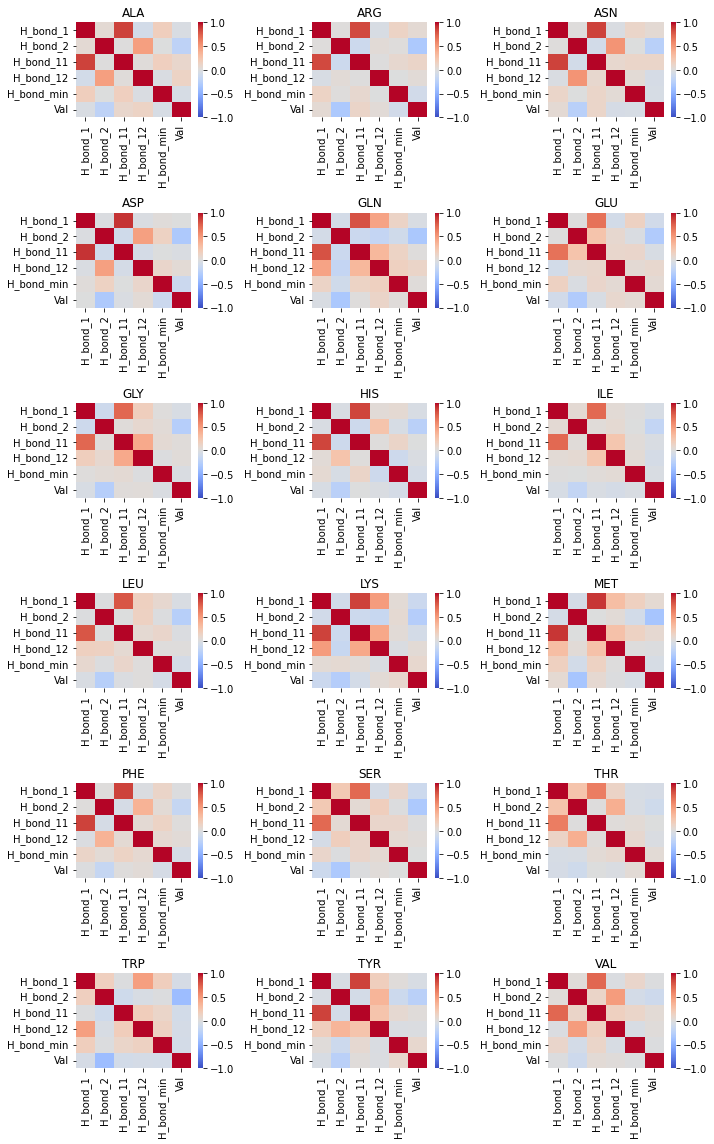

In [374]:
res_groups = df_15N.groupby(by='Comp_ID')

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 16))
for res, ax in zip(res_list, axs.ravel()):
    df_15N_Res = res_groups.get_group(res)

    df_15N_Res.drop(df_15N_Res.loc[df_15N_Res['H_bond_min'] > 3.0].index, inplace=True)   
    pears=np.round(df_15N_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)

    sb_cor = df_15N_Res[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12','H_bond_min', 'Val']].corr()

    #import seaborn as sns 
    cor_map = sns.heatmap(sb_cor, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(res)
fig.tight_layout()

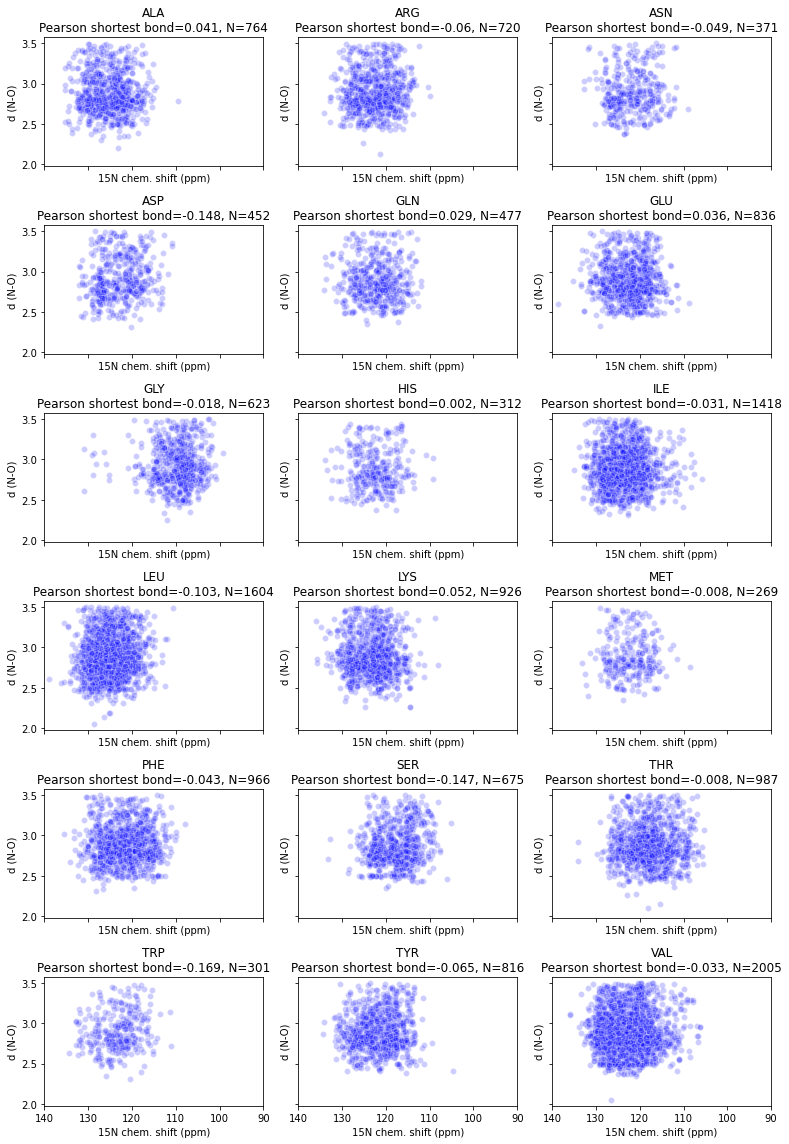

In [375]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)
    df_15N_Res.drop(df_15N_Res.loc[df_15N_Res['H_bond_min'] > 3.5].index, inplace=True)
    
    pears=np.round(df_15N_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_min, alpha=0.2, c='b', edgecolors='white')

    
    ax.set_title(res+"\n"+f"Pearson shortest bond={pears}, N={len(df_15N_Res.dropna())}")
    ax.set_xlim(140, 90)
    #ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Shortest_15N.jpeg', dpi=200)

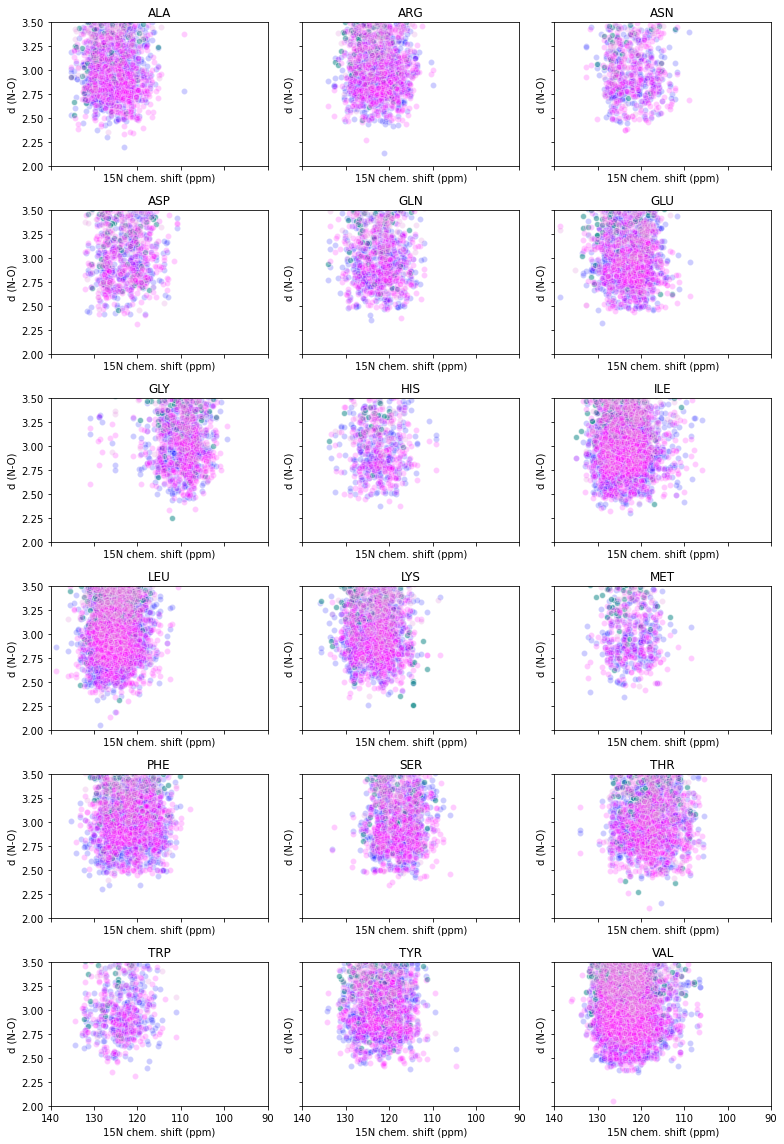

In [376]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)
    df_15N_Res.drop(df_15N_Res.loc[df_15N_Res['H_bond_min'] > 3.5].index, inplace=True)

    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_1, alpha=0.2, c='b', edgecolors='white') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_2, alpha=0.5, c='teal', edgecolors='white') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_11, alpha=0.2, c='magenta', edgecolors='white') # acceptor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_12, alpha=0.2, c='orchid', edgecolors='white') # acceptor

    ax.set_title(res)
    ax.set_xlim(140, 90)
    ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_All.jpeg', dpi=200)

### 3.1.2 1H

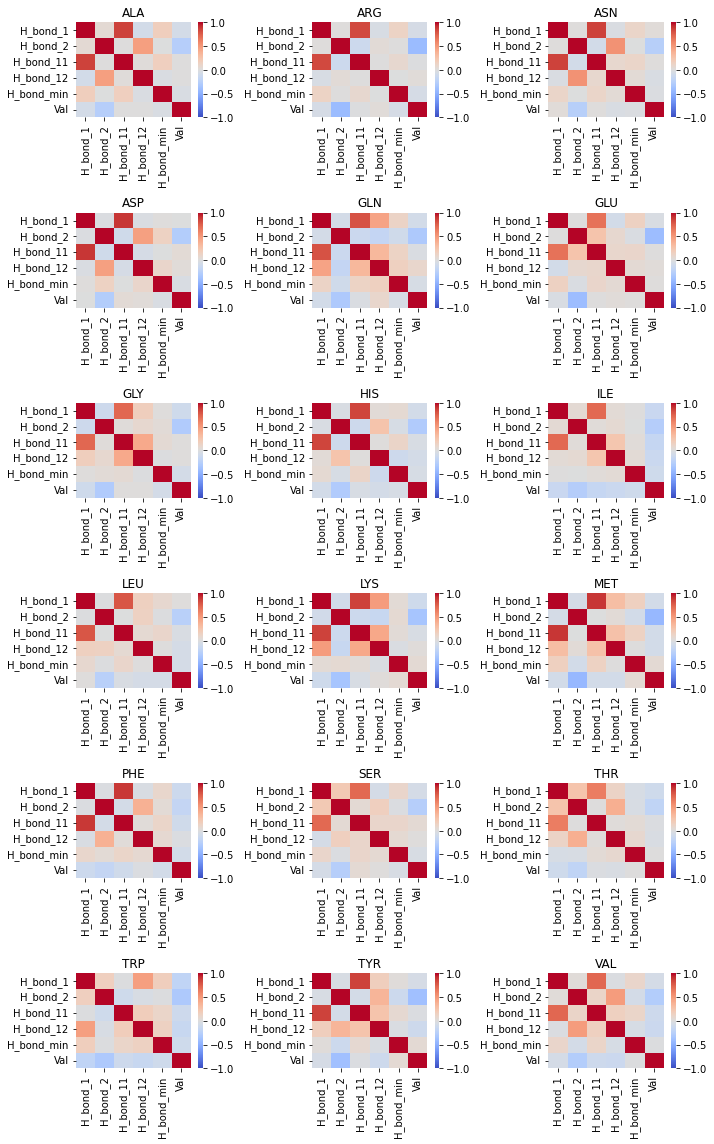

In [378]:
res_groups = df_1H.groupby(by='Comp_ID')

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 16))
for res, ax in zip(res_list, axs.ravel()):
    df_1H_Res = res_groups.get_group(res)

    df_1H_Res.drop(df_1H_Res.loc[df_1H_Res['H_bond_min'] > 3.0].index, inplace=True)   
    pears=np.round(df_1H_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)

    sb_cor = df_1H_Res[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12','H_bond_min', 'Val']].corr()

    #import seaborn as sns 
    cor_map = sns.heatmap(sb_cor, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(res)
fig.tight_layout()

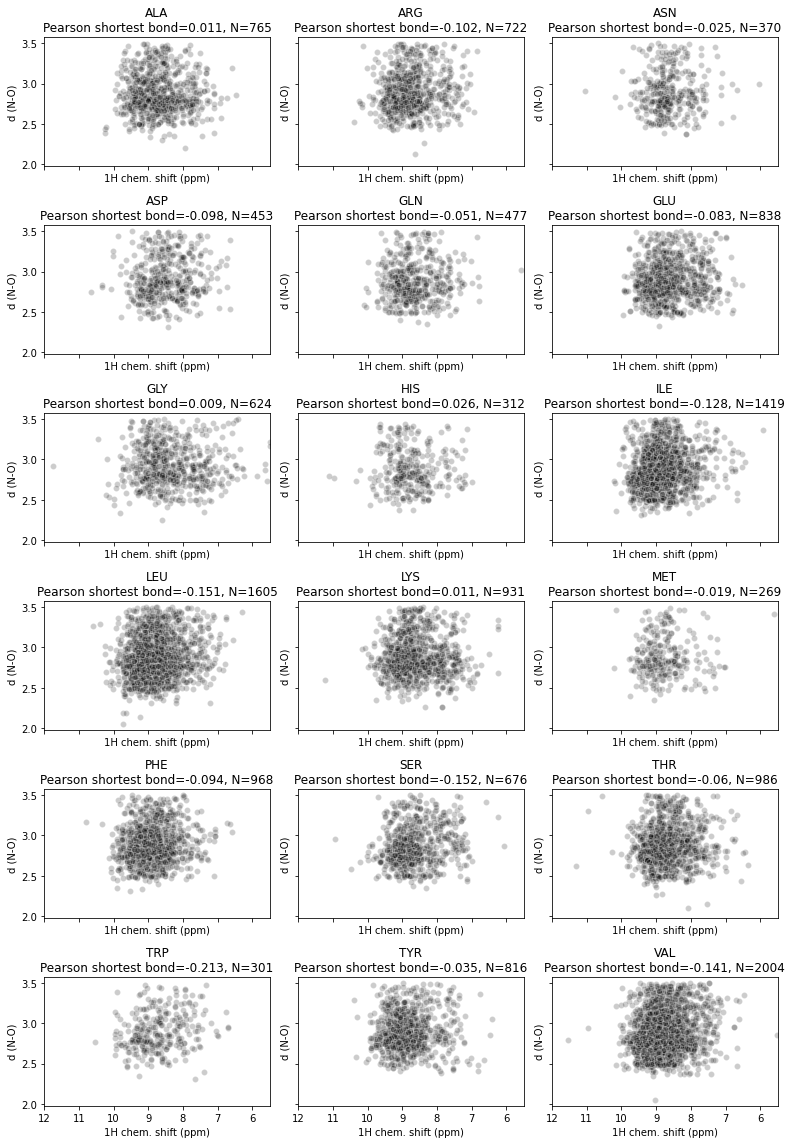

In [379]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_1H.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_1H_Res = res_groups.get_group(res)
    df_1H_Res.drop(df_1H_Res.loc[df_1H_Res['H_bond_min'] > 3.5].index, inplace=True)
    
    pears=np.round(df_1H_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)
    ax.scatter(df_1H_Res.Val, df_1H_Res.H_bond_min, alpha=0.2, c='k', edgecolors='white')

    
    ax.set_title(res+"\n"+f"Pearson shortest bond={pears}, N={len(df_1H_Res.dropna())}")
    ax.set_xlim(12, 5.5)
    #ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('1H chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Shortest_1H.jpeg', dpi=200)

## 3.2 Chem Shift vs. H-bond energy

(How is this reliable if lengths are crazy large!)

### 3.2.1. 15N

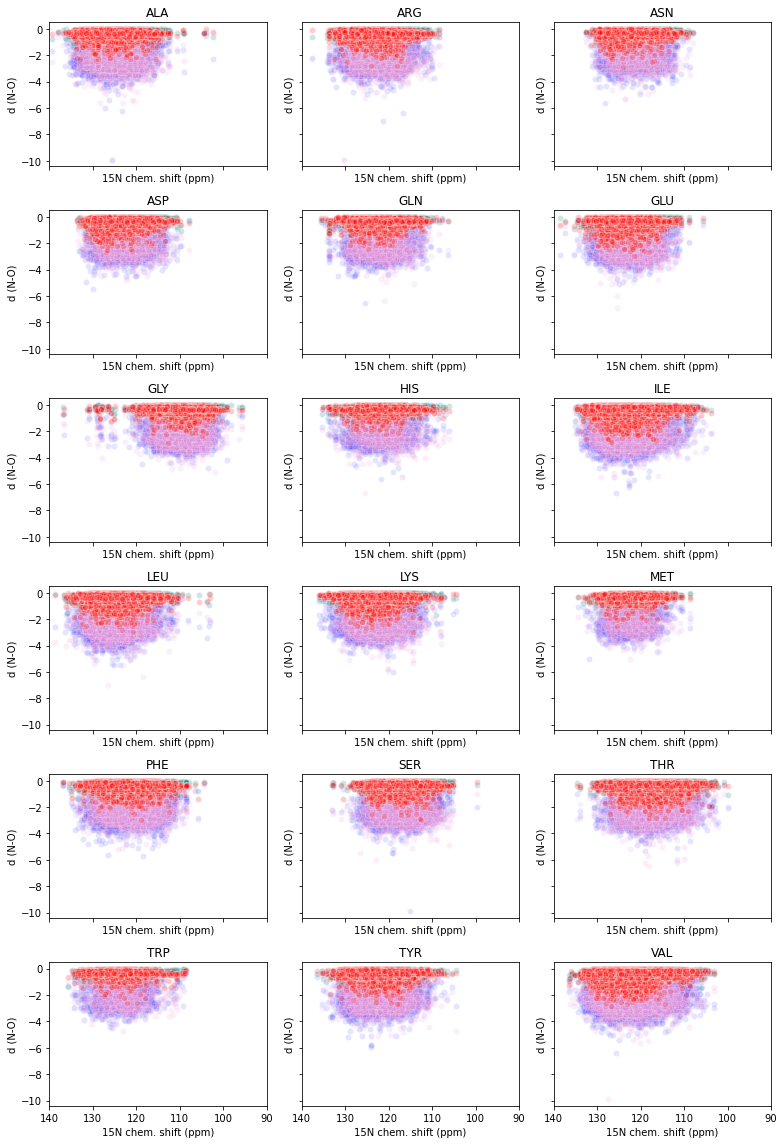

In [377]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)
    #df_15N_Res.drop(df_15N_Res.loc[df_15N_Res['H_bond_min'] > 3.5].index, inplace=True)

    ax.scatter(df_15N_Res.Val, df_15N_Res['NH-O1_En'], alpha=0.1, c='b', edgecolors='white') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res['NH-O2_En'], alpha=0.2, c='teal', edgecolors='white') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res['O-NH1_En'], alpha=0.1, c='orchid', edgecolors='white') # acceptor
    ax.scatter(df_15N_Res.Val, df_15N_Res['O-NH2_En'], alpha=0.2, c='red', edgecolors='white') # acceptor

    ax.set_title(res)
    ax.set_xlim(140, 90)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Energy_15N.jpeg', dpi=200)

### 3.2.2. 1H

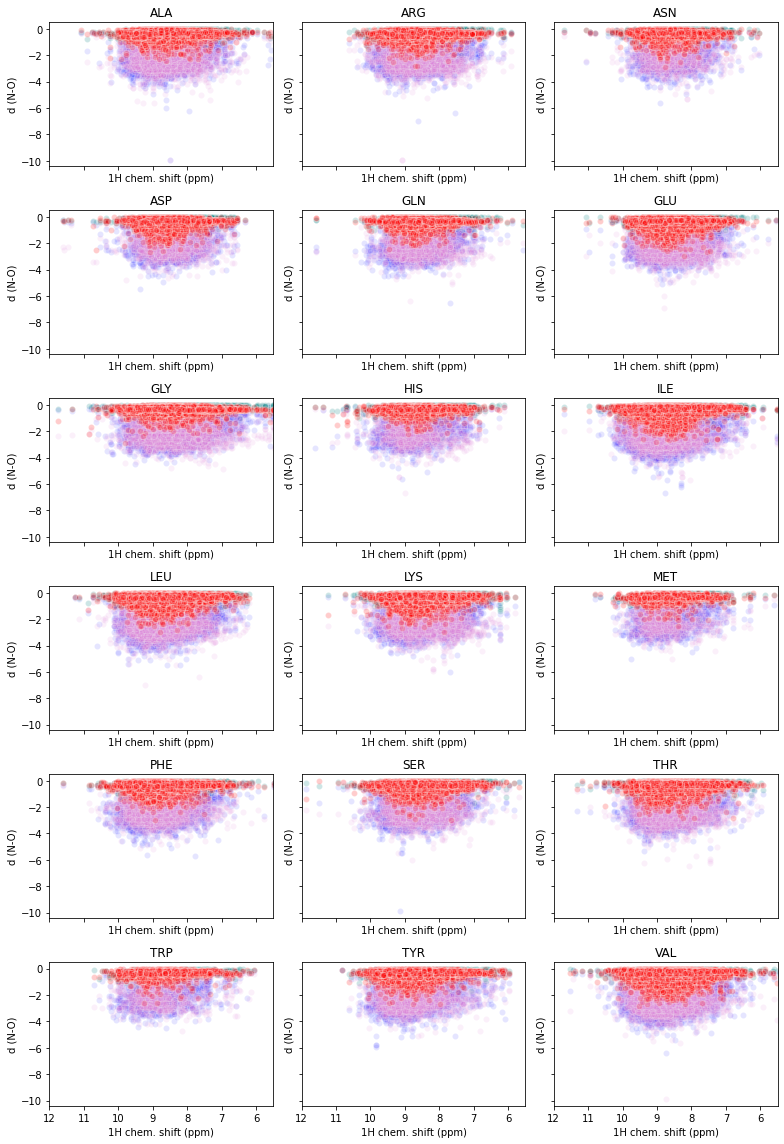

In [380]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_1H.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_1H_Res = res_groups.get_group(res)
    #df_1H_Res.drop(df_1H_Res.loc[df_1H_Res['H_bond_min'] > 3.5].index, inplace=True)

    ax.scatter(df_1H_Res.Val, df_1H_Res['NH-O1_En'], alpha=0.1, c='b', edgecolors='white') # donor
    ax.scatter(df_1H_Res.Val, df_1H_Res['NH-O2_En'], alpha=0.2, c='teal', edgecolors='white') # donor
    ax.scatter(df_1H_Res.Val, df_1H_Res['O-NH1_En'], alpha=0.1, c='orchid', edgecolors='white') # acceptor
    ax.scatter(df_1H_Res.Val, df_1H_Res['O-NH2_En'], alpha=0.2, c='red', edgecolors='white') # acceptor

    ax.set_title(res)
    ax.set_xlim(12, 5.5)
    ax.set_xlabel('1H chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Energy_1H.jpeg', dpi=200)

# 4. Neighbor search

In [ ]:
pdbdir='D://Structures/' # to drop PDBs to - careful with disc size!

df = df.reset_index()
df = df.set_index(['PDB_ID'])

parser = MMCIFParser()
pdbl = PDBList()
problems = []  

for pdb_id in df.index.unique()[17:]:
    
    df = df.reset_index()
    df = df.set_index(['PDB_ID'])
    
    pdbl.retrieve_pdb_file(pdb_id.upper(), pdir=pdbdir)
    structure = parser.get_structure("protein", pdbdir+pdb_id+".cif")
    try:
        chain = structure[0]["A"]
    except KeyError:
        problems.append(pdb_id)
        continue

    # Measuring the H-bonds which were identified by DSSP 
    residues = list(df.loc[pdb_id, 'Seq_ID'].unique())
    
    df = df.reset_index()
    df = df.set_index(['PDB_ID', 'Seq_ID'])

    for i_num in residues:
        try:
        search_set = O_atom_list
            ## search for each Nitrogen individually
            search_set.append(chain[int(rnum)]['N'])
            H_bond_finder=NeighborSearch(search_set)
            raw_out = H_bond_finder.search_all(radius=3.6, level='R')
            i=0
            for pair in raw_out:
                print(pair)
                for res in pair:
                    if res.get_id()[1] == rnum:
                        # Potential partners found
                        ## Initialize atoms
                        if pair[0].get_id()[1] == rnum:
                            partner_id = pair[1].get_id()[1]
                            n = pair[0]['N'] # our N
                            o = pair[1]['O'] # other's O
                        else:
                            partner_id = pair[0].get_id()[1]
                            n = pair[1]['N'] # our N
                            o = pair[0]['O'] # other's O

                        # Exclude direct sequential neighbors!
                        print('Residue:', rnum, 'Partner', partner_id)
                        if abs(partner_id-rnum) < 2:
                            continue
                        else:
                            dist = n - o
                            print(dist)
                            if dist < H_bond_max_length:
                                # Found an H-bond! Now write it down
                                i+=1 
                                pdb_N_df.at[rnum, f'H_bond_partner_{i}'] = partner_id
                                pdb_N_df.at[rnum, f'H_bond_{i}_len'] = dist

            df.loc[(pdb_id, i_num), 'H_bond_1'] = H_bond1_d
            df.loc[(pdb_id, i_num), 'H_bond_2'] = H_bond2_d
            df.loc[(pdb_id, i_num), 'H_bond_11'] = H_bond11_d
            df.loc[(pdb_id, i_num), 'H_bond_12'] = H_bond12_d
        except:
            problems.append(pdb_id)
            continue
    df.to_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t') 
    
#amide_N_H_bonds.to_csv('D://amide_N_H_bonds.csv')    
search_set = O_atom_list
                ## search for each Nitrogen individually

                search_set.append(chain[int(rnum)]['N'])
                H_bond_finder=NeighborSearch(search_set)
                raw_out = H_bond_finder.search_all(radius=4.1, level='R')
                i=0
                for pair in raw_out:
                    print(pair)
                    for res in pair:
                        if res.get_id()[1] == rnum:
                            # Potential partners found
                            ## Initialize atoms
                            if pair[0].get_id()[1] == rnum:
                                partner_id = pair[1].get_id()[1]
                                n = pair[0]['N'] # our N
                                o = pair[1]['O'] # other's O
                            else:
                                partner_id = pair[0].get_id()[1]
                                n = pair[1]['N'] # our N
                                o = pair[0]['O'] # other's O

                            # Exclude direct sequential neighbors!
                            print('Residue:', rnum, 'Partner', partner_id)
                            if abs(partner_id-rnum) < 2:
                                continue
                            else:
                                dist = n - o
                                print(dist)
                                if dist < H_bond_max_length:
                                    # Found an H-bond! Now write it down
                                    i+=1 
                                    pdb_N_df.at[rnum, f'H_bond_partner_{i}'] = partner_id
                                    pdb_N_df.at[rnum, f'H_bond_{i}_len'] = dist
                print(pdb_N_df.head(5))

--------

# Examples and tests

## Visualizer for troubleshooting

In [184]:
pdbdir='D://Structures/'
pdb_id_test = '6yq5'

parser = MMCIFParser()
pdbl = PDBList()

pdbl.retrieve_pdb_file(pdb_id_test.upper(), pdir=pdbdir)
structure = parser.get_structure("protein", pdbdir+pdb_id_test+".cif")
chain = structure[0]["A"]
view = nv.show_biopython(structure)
view

Structure exists: 'D://Structures/6yq5.cif' 


KeyboardInterrupt: 

Accessing individual entries

In [140]:
#res_names

pdb_id = '1b4c'
bmrb_id = rel.loc[pdb_id.upper()][0]

dssp_df = pd.DataFrame.from_dict(dssp[0]).T
dssp_df.reset_index(inplace=True)
dssp_df.drop('level_1', axis=1, inplace=True)
dssp_df.columns = dssp_cols
dssp_df=dssp_df.loc[dssp_df.CHAIN == dssp_df.CHAIN.unique()[0]] # only the first chain!

dssp = make_dssp_dict(f"C:\\Users\\Krairy\\OneDrive\\PhD\\dssp\\{pdb_id}.dssp")

## BMRB
nmrstar = pynmrstar.Entry.from_database(bmrb_id)
loops = nmrstar.get_saveframes_by_category('assigned_chemical_shifts')[0]
shifts = loops['_Atom_chem_shift']
data = StringIO(shifts.get_data_as_csv().replace("_Atom_chem_shift.", ""))
df_bmrb = pd.read_csv(data, index_col=0)
df_bmrb = df_bmrb.query('Atom_ID == "H" or Atom_ID == "N" or Atom_ID == "CA" or Atom_ID == "CB"')

## Assembley
df_ = pd.DataFrame()
df_ = dssp_df['CHAIN # AA SS PHI PSI NH-O1_En O-NH1_idx O-NH1_En NH-O2_idx NH-O2_En O-NH2_idx O-NH2_En'.split()]
df_ = pd.merge(df_, df_bmrb['Seq_ID Comp_ID Atom_ID Val'.split()], 
                       left_on='#', right_on='Seq_ID' , how='outer') ## Here the magic happens!!

### Check for sequence match!!


## If all good
df_['BMRB_ID'] = bmrb_id
df_['PDB_ID'] = pdb_id
#df_ = df_.query('SS == "E" or SS == "B"')
df_

CHAIN    #   AA   SS    PHI   PSI NH-O1_En O-NH1_idx O-NH1_En NH-O2_idx  \
0       A    1    T    -  360.0  84.1      0.0        85     -0.2         0   
1       A    2    G    - -171.5  99.4     -0.1        27     -0.1        23   
2       A    2    G    - -171.5  99.4     -0.1        27     -0.1        23   
3       A    2    G    - -171.5  99.4     -0.1        27     -0.1        23   
4       A    2    G    - -171.5  99.4     -0.1        27     -0.1        23   
..    ...  ...  ...  ...    ...   ...      ...       ...      ...       ...   
347   NaN  NaN  NaN  NaN    NaN   NaN      NaN       NaN      NaN       NaN   
348   NaN  NaN  NaN  NaN    NaN   NaN      NaN       NaN      NaN       NaN   
349   NaN  NaN  NaN  NaN    NaN   NaN      NaN       NaN      NaN       NaN   
350   NaN  NaN  NaN  NaN    NaN   NaN      NaN       NaN      NaN       NaN   
351   NaN  NaN  NaN  NaN    NaN   NaN      NaN       NaN      NaN       NaN   

    NH-O2_En O-NH2_idx O-NH2_En  Seq_ID Comp_ID Atom_ID     Val  BMRB_ID  \
0        0.0         2     -0.1     NaN     NaN     NaN     NaN     5544   
1       -0.1        83     -0.0     2.0     SER       H    9.84     5544   
2       -0.1        83     -0.0     2.0     SER      CA   57.30     5544   
3       -0.1        83     -0.0     2.0     SER      CB   65.26     5544   
4       -0.1        83     -0.0     2.0     SER       N  121.15     5544   
..       ...       ...      ...     ...     ...     ...     ...      ...   
347      NaN       NaN      NaN    91.0     HIS       N  119.25     5544   
348      NaN       NaN      NaN    92.0     GLU       H    8.13     5544   
349      NaN       NaN      NaN    92.0     GLU      CA   58.11     5544   
350      NaN       NaN      NaN    92.0     GLU      CB   30.73     5544   
351      NaN       NaN      NaN    92.0     GLU       N  127.83     5544   

    PDB_ID  
0     1b4c  
1     1b4c  
2     1b4c  
3     1b4c  
4     1b4c  
..     ...  
347   1b4c  
348   1b4c  
349   1b4c  
350   1b4c  
351   1b4c  

[352 rows x 19 columns]

## Fetching the BMRB data with `pynmrstar`

In [4]:
##### test

try:
    bmrb_id = int(input("Enter the BMRB ID \n For example, 51228 for Alex's SH3 assignments "))
    nmrstar = pynmrstar.Entry.from_database(bmrb_id)

except ValueError:
    print("Not a number")
except OSError:
    print(f"Entry {bmrb_id} does not exist in the public database")
    
nmrstar = pynmrstar.Entry.from_database(bmrb_id)
loops = nmrstar.get_saveframes_by_category('assigned_chemical_shifts')[0]
shifts = loops['_Atom_chem_shift']

## print(shifts)

data = StringIO(shifts.get_data_as_csv().replace("_Atom_chem_shift.", ""))
df = pd.read_csv(data, index_col=0)
## print(df.columns)
df.tail()

Enter the BMRB ID 
 For example, 51228 for Alex's SH3 assignments  51228


Assembly_atom_ID  Entity_assembly_ID Entity_assembly_asym_ID  Entity_ID  \
ID                                                                            
559                .                   1                       .          1   
560                .                   1                       .          1   
561                .                   1                       .          1   
562                .                   1                       .          1   
563                .                   1                       .          1   

     Comp_index_ID  Seq_ID Comp_ID Atom_ID Atom_type  Atom_isotope_number  \
ID                                                                          
559             61      61     LEU       N         N                   15   
560             62      62     ASP       H         H                    1   
561             62      62     ASP      CA         C                   13   
562             62      62     ASP      CB         C                   13   
563             62      62     ASP       N         N                   15   

     ...  Occupancy  Resonance_ID Auth_entity_assembly_ID  Auth_asym_ID  \
ID   ...                                                                  
559  ...          .             .                       .             .   
560  ...          .             .                       .             .   
561  ...          .             .                       .             .   
562  ...          .             .                       .             .   
563  ...          .             .                       .             .   

    Auth_seq_ID Auth_comp_ID Auth_atom_ID Details Entry_ID  \
ID                                                           
559          61          LEU            N       .    51228   
560          62          ASP            H       .    51228   
561          62          ASP           CA       .    51228   
562          62          ASP           CB       .    51228   
563          62          ASP            N       .    51228   

     Assigned_chem_shift_list_ID  
ID                                
559                            1  
560                            1  
561                            1  
562                            1  
563                            1  

[5 rows x 25 columns]

## Opening the DSSP file by PDB ID

In [101]:
dssp = make_dssp_dict(f"C:\\Users\\Krairy\\OneDrive\\PhD\\dssp\\{pdb_id}.dssp")

In [79]:
dssp_df = pd.DataFrame.from_dict(dssp[0]).T
dssp_df.reset_index(inplace=True)
dssp_df.drop('level_1', axis=1, inplace=True)
dssp_df.columns = dssp_cols
dssp_df=dssp_df.loc[dssp_df.CHAIN == dssp_df.CHAIN.unique()[0]] # only the first chain!
dssp_df

CHAIN AA SS  ASA    PHI    PSI   # NH-O1_idx NH-O1_En O-NH1_idx O-NH1_En  \
0      A  A  -   92  360.0  100.4   1         0      0.0        43     -0.2   
1      A  S  -   62 -154.9   25.1   2        39     -0.1        42     -0.2   
2      A  a  -   12  -43.7  103.7   3         1     -0.2         3     -0.6   
3      A  W  G   67  -77.1  -23.7   4         1     -0.2         3     -1.3   
4      A  A  G    0  -63.7  -24.1   5         1     -0.3         4     -2.2   
5      A  Q  G  134  -51.5  -37.4   6        -3     -0.6        -1     -0.3   
6      A  S  G  114  -44.5  -43.2   7        -3     -1.3        -1     -0.3   
7      A  Q  T  119  -89.4  -31.9   8        -3     -1.6        -1     -0.2   
8      A  G  T   58  118.9   33.8   9        -4     -2.2        -3     -0.2   
9      A  Y  -   94 -103.3  163.1  10        -5     -1.4        -1     -0.2   
10     A  N  E   86  -75.1 -150.5  11        26     -1.1        28     -1.5   
11     A  a  E   38 -147.1  133.1  12        26     -0.3         2     -0.3   
12     A  b  -    1  -72.9  133.6  13        26     -1.4        28     -0.3   
13     A  N  S   97  -75.4  130.5  14        -2     -0.3         4     -0.1   
14     A  N  -  104   57.7   93.2  15        -2     -0.3         3     -0.7   
15     A  P  G   18  -76.9  -30.8  16         0      0.0         3     -1.1   
16     A  S  G   97  -78.0   17.0  17         1     -0.2        -2     -0.1   
17     A  S  G   96 -151.2   17.0  18        -3     -0.7         2     -0.6   
18     A  T  S   20 -118.0   98.1  19        -3     -1.1        -1     -0.1   
19     A  K  -  179  -43.9  118.0  20        -2     -0.6        12     -0.6   
20     A  V  E   44  -68.0  123.8  21         1     -0.2        10     -0.3   
21     A  E  E  103 -106.9  -20.6  22         8     -0.9         2     -0.2   
22     A  Y  E   71 -103.3  166.8  23         7     -0.8         7     -1.1   
23     A  T  E   84 -170.7  110.4  24         5     -0.2         2     -0.2   
24     A  D  E   80 -150.7 -168.1  25         3     -1.8         3     -2.3   
25     A  A  T  115  -64.4   -6.9  26         1     -0.3         3     -0.1   
26     A  S  T   17  -87.9    4.8  27         1     -0.3         2     -0.5   
27     A  G  E   35  102.6 -127.2  28        -3     -2.3        -3     -1.8   
28     A  Q  E   99 -130.5  146.7  29        11     -0.6        11     -1.2   
29     A  W  E    2 -124.4 -176.3  30        -7     -1.1        -8     -0.9   
30     A  G  E    0 -140.7  150.5  31         7     -1.4         7     -1.3   
31     A  V  E   61 -108.3  132.4  32       -12     -0.6         2     -0.3   
32     A  Q  E   80 -151.2  132.3  33         3     -1.5         3     -1.4   
33     A  N  T  165   66.8    8.9  34        -2     -0.3         3     -0.1   
34     A  G  T   74   81.9   24.8  35         1     -0.3         2     -0.4   
35     A  Q  E   80 -131.3  141.3  36        -3     -1.4        -3     -1.5   
36     A  W  E   72  -76.6  138.0  37        -2     -0.4       -26     -1.1   
37     A  b  E    6 -133.3  145.3  38        -7     -1.3        -7     -1.4   
38     A  G  E    0  -83.9  122.9  39       -28     -1.5       -26     -1.4   
39     A  I  E   13  -89.9  118.5  40       -11     -1.2       -11     -0.6   
40     A  D  -   19 -126.9  135.3  41        -2     -0.7         3     -0.2   
41     A  Y  S  186  -72.0  -23.6  42        -2     -0.4        -1     -0.1   
42     A  S  S   71  -90.1  -13.5  43       -41     -0.1         3     -0.3   
43     A  Y  -   59  -73.7  165.6  44        -3     -0.2        -4     -0.0   
44     A  G  -   51   85.1   21.4  45         1     -0.3        -1     -0.2   
45     A  Q  -  229 -106.0  360.0  46        -3     -0.3        -1     -0.3   

   NH-O2_idx NH-O2_En O-NH2_idx O-NH2_En  
0          0      0.0        41     -0.0  
1         44     -0.0         2     -0.1  
2         40     -0.1         4     -0.3  
3         23     -0.2         4     -0.4  
4          2     -0.2         3     -1.6  
5          1     -0.3        -2

In [47]:
bmrb_id = 3322
pdb_id = rel.loc[bmrb_id][0]

nmrstar = pynmrstar.Entry.from_database(bmrb_id)
loops = nmrstar.get_saveframes_by_category('assigned_chemical_shifts')[0]
shifts = loops['_Atom_chem_shift']

## print(shifts)

data = StringIO(shifts.get_data_as_csv().replace("_Atom_chem_shift.", ""))
df_bmrb = pd.read_csv(data, index_col=0)

In [76]:
df_bmrb = df_bmrb.query('Atom_ID == "H" or Atom_ID == "N" or Atom_ID == "CA" or Atom_ID == "CB"')
df_bmrb

Assembly_atom_ID  Entity_assembly_ID  Entity_ID  Comp_index_ID  Seq_ID  \
ID                                                                           
3                  .                   1          1              2       2   
7                  .                   1          1              2       2   
8                  .                   1          1              3       3   
12                 .                   1          1              3       3   
13                 .                   1          1              4       4   
..               ...                 ...        ...            ...     ...   
351                .                   1          1             50      50   
352                .                   1          1             51      51   
358                .                   1          1             51      51   
359                .                   1          1             52      52   
363                .                   1          1             52      52   

    Comp_ID Atom_ID Atom_type  Atom_isotope_number     Val  ...  Occupancy  \
ID                                                          ...              
3       SER       H         H                    1    8.31  ...          .   
7       SER       N         N                   15  123.30  ...          .   
8       CYS       H         H                    1    8.20  ...          .   
12      CYS       N         N                   15  116.30  ...          .   
13      TRP       H         H                    1    9.44  ...          .   
..      ...     ...       ...                  ...     ...  ...        ...   
351     ASN       N         N                   15  118.70  ...          .   
352     GLU       H         H                    1    8.53  ...          .   
358     GLU       N         N                   15  120.80  ...          .   
359     SER       H         H                    1    8.03  ...          .   
363     SER       N         N                   15  122.30  ...          .   

    Resonance_ID  Auth_entity_assembly_ID Auth_asym_ID Auth_seq_ID  \
ID                                                                   
3              .                        .            .           .   
7              .                        .            .           .   
8              .                        .            .           .   
12             .                        .            .           .   
13             .                        .            .           .   
..           ...                      ...          ...         ...   
351            .                        .            .           .   
352            .                        .            .           .   
358            .                        .            .           .   
359            .                        .            .           .   
363            .                        .            .           .   

    Auth_comp_ID Auth_atom_ID Details Entry_ID Assigned_chem_shift_list_ID  
ID                                                                          
3              .            .       .     3322                           1  
7              .            .       .     3322                           1  
8              .            .       .     3322                           1  
12             .            .       .     3322                           1  
13             .            .       .     3322                           1  
..           ...          ...     ...      ...                         ...  
351            .            .       .     3322                           1  
352            .            .       .     3322                           1  
358            .            .       .     3322                           1  
359            .            .       .     3322                           1  
363            .            .       .     3322                           1  

[100 rows x 23 columns]

In [108]:
df_ = pd.DataFrame()
df_ = dssp_df['CHAIN # AA SS PHI PSI NH-O1_En O-NH1_idx O-NH1_En NH-O2_idx NH-O2_En O-NH2_idx O-NH2_En'.split()]
df_ = pd.merge(df_, df_bmrb['Seq_ID Comp_ID Atom_ID Val'.split()], 
               left_on='#', right_on='Seq_ID' , how='outer') ## Here the magic happens!!
df_['BMRB_ID'] = bmrb_id
df_['PDB_ID'] = pdb_id
df_ = df_.query('SS == "E" or SS == "B"') # for the current research we need only Extended structures
df_.to_csv(csv_dir+f'/{pdb_id}_{bmrb_id}.csv')

# 2. Creating the ultimate dataframe from DSSP and PDB data

## 1.2. Reading DSSP files with `Bio.PDB`

In [89]:
#amide_HN=pd.read_csv(wdir+'Atom_chem_shifts_HN.tab', sep='\t')
amide_N=pd.read_csv(wdir+'Atom_chem_shifts_N.tab', sep='\t')

In [90]:
amide_N

Unnamed: 0   ID  Entity_ID  PDB_model_num  Entry_ID  Seq_ID Comp_ID  \
0                14    7          1            NaN     10001       1     ILE   
1                19   12          1            NaN     10001       2     ASN   
2                32   25          1            NaN     10001       3     TRP   
3                40   33          1            NaN     10001       4     LYS   
4                44   37          1            NaN     10001       5     GLY   
...             ...  ...        ...            ...       ...     ...     ...   
1191749    11213823  139          1            NaN       971      78     VAL   
1191750    11213825  141          1            NaN       971      79     LEU   
1191751    11213827  143          1            NaN       971      80     SER   
1191752    11213832  148          1            NaN       971      81     GLN   
1191753    11213834  150          1            NaN       971      82     LYS   

        Atom_ID Atom_type    Val  
0             N         N   36.9  
1             N         N  126.5  
2             N         N  125.6  
3             N         N  116.7  
4             N         N  107.2  
...         ...       ...    ...  
1191749       N         N  125.1  
1191750       N         N  116.1  
1191751       N         N  115.0  
1191752       N         N  122.4  
1191753       N         N  126.4  

[1191754 rows x 10 columns]

**DO NOT** run the following! Results in `MemoryError`!

In [ ]:
## DONT RUN!!!
##### df=pd.merge(right=amide_N.iloc[:, 4:], left=amide_HN.iloc[:, 4:], on='Entry_ID')

MemoryError: Unable to allocate 4.36 GiB for an array with shape (3, 194955221) and data type object

In [11]:
idx = amide_N.set_index('Entry_ID').index.intersection(rel.index)
idx # This is our list of IDs!

Int64Index([10002, 10006, 10008, 10009, 10011, 10012, 10013, 10024, 10025,
            10026,
            ...
             7401,  7414,  7419,  7420,  7421,  7423,  7424,  7425,  7430,
             9500],
           dtype='int64', length=5117)

In [12]:
amide_N = amide_N.set_index('Entry_ID')[['Seq_ID', 'Comp_ID', 'Atom_ID', 'Val']]
amide_HN = amide_HN.set_index('Entry_ID')[['Seq_ID', 'Comp_ID', 'Atom_ID', 'Val']]

In [13]:
amide_N = amide_N.loc[idx]
amide_HN = amide_HN.loc[idx]

In [14]:
#rel.index.name = 'Entry_ID'
amide_N = pd.merge(amide_N, rel, left_index=True, right_index=True)
amide_HN = pd.merge(amide_HN, rel, left_index=True, right_index=True)

In [ ]:
rel.loc[idx].to_csv(wdir+'pdb_id.csv')

In [ ]:
wdir+'pdb_id.csv'

'~//sciebo//PDB analysis//pdb_id.csv'

## 2. Fetching and processing the PDBs

maybe one-third of the dataset at a time..?

In [84]:
pdbdir='D://pdb/dssp_check/'
dsspdir='D://dssp/'
parser = MMCIFParser()
pdbl = PDBList()

In [15]:
amide_N.dropna()

Seq_ID Comp_ID Atom_ID      Val pdb_id
3322        2     SER       N  123.300   1E8P
3322        2     SER       N  123.300   1E8Q
3322        3     CYS       N  116.300   1E8P
3322        3     CYS       N  116.300   1E8Q
3322        4     TRP       N  130.000   1E8P
...       ...     ...     ...      ...    ...
50411     102     ASN       N  114.765   7JK8
50411     103     LEU       N  114.782   7JK8
50411     104     LEU       N  113.569   7JK8
50411     105     SER       N  111.942   7JK8
50411     106     ARG       N  129.385   7JK8

[498566 rows x 5 columns]

#### **WARNING!** Fetching structures

In [ ]:
flag='n'
id_start = 0
id_finish = 3000
n=id_finish - id_start
flag = input(f'Confirm downloading {n} pdb files (approx. {n*66}/1024 Mb): y/n')
if flag=='y':
    for pdb_id in rel.iloc[id_start:id_finish, 0]:
        pdbl.retrieve_pdb_file(pdb_id, pdir=pdbdir)
else:
    print('No files fetched')
    flag='n'

Structure exists: 'D://pdb/1a5j.cif' 


Structure exists: 'D://pdb/1axh.cif' 
Structure exists: 'D://pdb/1axh.cif' 


Structure exists: 'D://pdb/1azp.cif' 


Structure exists: 'D://pdb/1azq.cif' 


Structure exists: 'D://pdb/1bnz.cif' 


Structure exists: 'D://pdb/1c8c.cif' 


Structure exists: 'D://pdb/1g03.cif' 


Structure exists: 'D://pdb/1gm1.cif' 
Structure exists: 'D://pdb/1gm1.cif' 
Structure exists: 'D://pdb/1gm1.cif' 


Structure exists: 'D://pdb/1j0t.cif' 


Structure exists: 'D://pdb/1jbh.cif' 


Structure exists: 'D://pdb/1je9.cif' 


Structure exists: 'D://pdb/1ji8.cif' 


Structure exists: 'D://pdb/1jmc.cif' 
Structure exists: 'D://pdb/1jmc.cif' 


Structure exists: 'D://pdb/1m8b.cif' 


Structure exists: 'D://pdb/1m8c.cif' 


Structure exists: 'D://pdb/1ma2.cif' 
Structure exists: 'D://pdb/1ma2.cif' 
Structure exists: 'D://pdb/1ma2.cif' 


Structure exists: 'D://pdb/1ma4.cif' 
Structure exists: 'D://pdb/1ma4.cif' 
Structure exists: 'D://pdb/1ma4.cif' 


Structure exists: 'D://pdb/1ma5.cif' 
Structure exists: 'D://pdb/1ma5.cif' 
Structure exists: 'D://pdb/1ma5.cif' 


Structure exists: 'D://pdb/1ma6.cif' 
Structure exists: 'D://pdb/1ma6.cif' 
Structure exists: 'D://pdb/1ma6.cif' 


Structure exists: 'D://pdb/1mmc.cif' 
Structure exists: 'D://pdb/1mmc.cif' 
Structure exists: 'D://pdb/1mmc.cif' 


Structure exists: 'D://pdb/1ps2.cif' 


Structure exists: 'D://pdb/1sap.cif' 


Structure exists: 'D://pdb/1sn6.cif' 


Structure exists: 'D://pdb/1unc.cif' 


In [ ]:
for pdb_id in rel.iloc[id_start:id_finish, 0]:
    structure=parser.get_structure("_", pdbdir+pdb_id)

In [ ]:
rel.head(5)

pdb_id
Entry_ID       
5625       1A2I
4201       1A3P
4114       1A5J
5517       1A5J
5702       1AXH

In [ ]:
rel=pd.read_csv(wdir+'./pdb_id.csv', index_col=0)
rel.head(5)

pdb_id
10002   1VEX
10006   1WFU
10008   1WFT
10009   1WFW
10011   2COM

#### Sorting in only E structures

Tidying up the results of the BioPDB DSSP output

In [ ]:
from glob import glob 
import os

fnames=list(glob(dsspdir+'*.dssp'))
for fname in fnames:
    basename = os.path.basename(fname)
    basename = basename.split('.')[0]
    #print(basename)
    result=make_dssp_dict(fname)[0]
    df=pd.DataFrame.from_dict(result)
    df_out = pd.concat( (df.T.loc[df.T[1]=='B'], df.T.loc[df.T[1]=='E']))
    #print(df_out.index.nlevels)
    if len(df_out.index.get_level_values(level=0).unique()) > 2:
        print(basename)
    #print(df_out.index.get_level_values(level=0).unique())
    #df_out.to_csv('D://dssp/sheet_csvs//'+basename+'.tab', sep='\t')

1f96
1mpe
2ka3
2ko8
2l9h
2le9
2lp7
2ltq
2m1k
2m3x
2m7w
2ma9
2mf6
2mjw
2mw4
2n18
2oii
4ca9
5jtl
5jtm
5jtn
5jto
5jtp
5jtq
5jtr
5k5g
6eka
6ob1
6oq2
6psi
6r8n
6rhy
6uyi
6uyj
6yq5


### **Warning!** 

running the folowing cell will generate A LOT of text output and will potentially crush the file! (fixable)

In [ ]:
from glob import glob 
import os

fnames=list(glob(dsspdir+'*.dssp'))

pdb_id='aaaa'
H_bond_max_length = 3.9 # Angstrom
#amide_N_H_bonds=pd.DataFrame()

pdb_N_df = pd.DataFrame()
problems=[]
counter=0
for fname in fnames[3633:4000]: # searching all available PDBs
    
    pdb_id = os.path.basename(fname)
    pdb_id = pdb_id.split('.')[0]
    
    # Retrieving DSSP data
    dssp_df = pd.read_csv('D://dssp/sheet_csvs//'+pdb_id+'.tab', sep='\t', index_col=[0,1])
    if dssp_df.empty:
        continue
    
    chains = dssp_df.index.get_level_values(level=0).unique()
    if chains[0] != 'A':
        continue
    else:
        ## Which residues of the given pdb (only chain A by definition) have E or B conformation?
        dssp_df = dssp_df.loc['A', :]
        pdb_E_idx = dssp_df.index
        bmrb_data = amide_N.where(amide_N['pdb_id']==pdb_id.upper()).dropna().set_index('Seq_ID').drop_duplicates()
        ## Which entries in this huge table belong to our pdb and which residues have assignments?
        pdb_res = bmrb_data.index

        ## Which of them are in E or B conformation?
        pdb_res_E_idx = pdb_res.intersection(pdb_E_idx)

        ## Creating a table with the residues of interest
        pdb_N_df = pd.DataFrame(index=pdb_res_E_idx)
        try:
            pdb_N_df['RES_type'] = bmrb_data.loc[pdb_res_E_idx, 'Comp_ID']
            pdb_N_df['R_type'] = dssp_df['0']
            pdb_N_df['Shift'] = bmrb_data.loc[pdb_res_E_idx, 'Val']
            pdb_N_df['Atom'] = 'N'
            pdb_N_df['Phi'] = dssp_df['3']
            pdb_N_df['Psi'] = dssp_df['4']
            pdb_N_df['DSSP'] = dssp_df['1']
            pdb_N_df['PDB_ID'] = pdb_id.upper()
            pdb_N_df['BMRB_ID'] = amide_N.where(amide_N['pdb_id']==pdb_id.upper()).dropna().index.unique()[0]
        except ValueError:
            continue
            
        #pdb_N_df.loc[]

        # Find potential H-bonds and measure their distance!
        ## Get the 3D structure (always chain A!)
        structure = parser.get_structure("_", pdbdir+pdb_id+".cif")
        try:
            chain = structure[0]["A"]
        except KeyError:
            problems.append(pdb_id)
            continue

        O_atom_list=[]
        for res in structure[0]["A"]:
            if res.has_id("O"):
                O_atom_list.append(res["O"]) # Gathering all oxygens in the structure
            else:
                continue

        try:
            for rnum in pdb_res_E_idx.values: # Check every E residue in our PDB!
                search_set = O_atom_list
                ## search for each Nitrogen individually

                search_set.append(chain[int(rnum)]['N'])
                H_bond_finder=NeighborSearch(search_set)
                raw_out = H_bond_finder.search_all(radius=4.1, level='R')
                i=0
                for pair in raw_out:
                    print(pair)
                    for res in pair:
                        if res.get_id()[1] == rnum:
                            # Potential partners found
                            ## Initialize atoms
                            if pair[0].get_id()[1] == rnum:
                                partner_id = pair[1].get_id()[1]
                                n = pair[0]['N'] # our N
                                o = pair[1]['O'] # other's O
                            else:
                                partner_id = pair[0].get_id()[1]
                                n = pair[1]['N'] # our N
                                o = pair[0]['O'] # other's O

                            # Exclude direct sequential neighbors!
                            print('Residue:', rnum, 'Partner', partner_id)
                            if abs(partner_id-rnum) < 2:
                                continue
                            else:
                                dist = n - o
                                print(dist)
                                if dist < H_bond_max_length:
                                    # Found an H-bond! Now write it down
                                    i+=1 
                                    pdb_N_df.at[rnum, f'H_bond_partner_{i}'] = partner_id
                                    pdb_N_df.at[rnum, f'H_bond_{i}_len'] = dist
                print(pdb_N_df.head(5))

            pdb_N_df.reset_index(inplace=True)
            pdb_N_df.rename(columns={'index': 'Res_ID'}, inplace=True)
            pdb_N_df.to_csv(f'D://H_bonds//{pdb_id}.csv')
        except KeyError:
            print('Problem with PDB ', pdb_id)
            problems.append(pdb_id)
            continue
    counter+=1

#amide_N_H_bonds.to_csv('D://amide_N_H_bonds.csv')

In [159]:
pdb_id='aaaa'
H_bond_max_length = 3.9 # Angstrom
#amide_N_H_bonds=pd.DataFrame()

pdb_N_df = pd.DataFrame()
problemsB=[]
counter=0
for problem in problems: # searching all problematic PDBs
    
    pdb_id = problem
    print(pdb_id)
    
    # Retrieving DSSP data
    dssp_df = pd.read_csv('D://dssp/sheet_csvs//'+pdb_id+'.tab', sep='\t', index_col=[0,1])
    if dssp_df.empty:
        continue
    
    chains = dssp_df.index.get_level_values(level=0).unique()
    if chains[0] != 'B':
        continue
    else:
        ## Which residues of the given pdb (only chain A by definition) have E or B conformation?
        dssp_df = dssp_df.loc['B', :]
        pdb_E_idx = dssp_df.index
        bmrb_data = amide_N.where(amide_N['pdb_id']==pdb_id.upper()).dropna().set_index('Seq_ID').drop_duplicates()
        ## Which entries in this huge table belong to our pdb and which residues have assignments?
        pdb_res = bmrb_data.index

        ## Which of them are in E or B conformation?
        pdb_res_E_idx = pdb_res.intersection(pdb_E_idx)

        ## Creating a table with the residues of interest
        pdb_N_df = pd.DataFrame(index=pdb_res_E_idx)
        try:
            pdb_N_df['RES_type'] = bmrb_data.loc[pdb_res_E_idx, 'Comp_ID']
            pdb_N_df['R_type'] = dssp_df['0']
            pdb_N_df['Shift'] = bmrb_data.loc[pdb_res_E_idx, 'Val']
            pdb_N_df['Atom'] = 'N'
            pdb_N_df['Phi'] = dssp_df['3']
            pdb_N_df['Psi'] = dssp_df['4']
            pdb_N_df['DSSP'] = dssp_df['1']
            pdb_N_df['PDB_ID'] = pdb_id.upper()
            pdb_N_df['BMRB_ID'] = amide_N.where(amide_N['pdb_id']==pdb_id.upper()).dropna().index.unique()[0]
        except ValueError:
            continue
            
        #pdb_N_df.loc[]

        # Find potential H-bonds and measure their distance!
        ## Get the 3D structure (always chain A!)
        structure = parser.get_structure("_", pdbdir+pdb_id+".cif")
        try:
            chain = structure[0]["B"]
        except KeyError:
            problemsB.append(pdb_id)
            continue

        O_atom_list=[]
        for res in structure[0]["B"]:
            if res.has_id("O"):
                O_atom_list.append(res["O"]) # Gathering all oxygens in the structure
            else:
                continue

        try:
            for rnum in pdb_res_E_idx.values: # Check every E residue in our PDB!
                search_set = O_atom_list
                ## search for each Nitrogen individually

                search_set.append(chain[int(rnum)]['N'])
                H_bond_finder=NeighborSearch(search_set)
                raw_out = H_bond_finder.search_all(radius=4.1, level='R')
                i=0
                for pair in raw_out:
                    print(pair)
                    for res in pair:
                        if res.get_id()[1] == rnum:
                            # Potential partners found
                            ## Initialize atoms
                            if pair[0].get_id()[1] == rnum:
                                partner_id = pair[1].get_id()[1]
                                n = pair[0]['N'] # our N
                                o = pair[1]['O'] # other's O
                            else:
                                partner_id = pair[0].get_id()[1]
                                n = pair[1]['N'] # our N
                                o = pair[0]['O'] # other's O

                            # Exclude direct sequential neighbors!
                            print('Residue:', rnum, 'Partner', partner_id)
                            if abs(partner_id-rnum) < 2:
                                continue
                            else:
                                dist = n - o
                                print(dist)
                                if dist < H_bond_max_length:
                                    # Found an H-bond! Now write it down
                                    i+=1 
                                    pdb_N_df.at[rnum, f'H_bond_partner_{i}'] = partner_id
                                    pdb_N_df.at[rnum, f'H_bond_{i}_len'] = dist
                print(pdb_N_df.head(5))

            pdb_N_df.reset_index(inplace=True)
            pdb_N_df.rename(columns={'index': 'Res_ID'}, inplace=True)
            pdb_N_df.to_csv(f'D://H_bonds//{pdb_id}.csv')
        except KeyError:
            print('Problem with PDB ', pdb_id)
            problemsB.append(pdb_id)
            continue
    counter+=1

#amide_N_H_bonds.to_csv('D://amide_N_H_bonds.csv')

2n62
2n67
2n79
2nd5
2npl


#### Troubleshooting

In [83]:
def id_from_path(path):
    pdb_id = os.path.basename(path)
    pdb_id = pdb_id.split('.')[0]
    return pdb_id
all_pdbs = [id_from_path(fname) for fname in list(glob(dsspdir+'*.dssp'))]

NameError: name 'dsspdir' is not defined

If stuck...

In [ ]:
all_pdbs.index(pdb_id) #PDB file number in the folder

363

Not processed PDBs

(could be due to wrong chain ID or missing residues)

In [144]:
print(problems)

['2n62', '2n67', '2n79', '2nd5', '2npl']


All not processed PDBs:

In [82]:
from glob import glob
processed_IDs = [id_from_path(path) for path in list(glob(f'D://H_bonds//*.csv'))]
all_IDs = [id_from_path(path) for path in list(glob(pdbdir+"*.cif"))]
PDBs_with_problems = set(all_IDs) - set(processed_IDs)
print(str(len(PDBs_with_problems))+" files had issues")
PDBs_with_problems

NameError: name 'id_from_path' is not defined

In [154]:
B=[]
C=[]
X=[]
for problem in PDBs_with_problems:
    structure = parser.get_structure("_", pdbdir+problem+".cif")
    try:
        chain = structure[0]["B"]
        B.append(problem)
    except KeyError:
        try:
            chain = structure[0]["C"]
            C.append(problem)
        except KeyError:
            print("Oh no "+problem)
            X.append(problem)
print("N B", len(B), "\tN C", len(C), "\tN X", len(X))

Oh no 2m6b
Oh no 5oao
Oh no 2keh
Oh no 2f76
Oh no 2jnh
Oh no 1u89
Oh no 2lva
Oh no 6bvw
Oh no 5mnw
Oh no 2n5j


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 2kkv
Oh no 5lwc
Oh no 2khf
Oh no 6drf
Oh no 2mzx
Oh no 2mv6


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 6txt
Oh no 2mwq
Oh no 2rnn
Oh no 2l84


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 2l9j
Oh no 5tn0
Oh no 2mfy
Oh no 5u9r
Oh no 2ahq
Oh no 1luk
Oh no 1r73
Oh no 6ez4
Oh no 1z8s
Oh no 2jpm
Oh no 6oc4
Oh no 2km4
Oh no 5u9v
Oh no 2ncj
Oh no 2n0h
Oh no 2kgd
Oh no 1mm5
Oh no 2rne
Oh no 2hgk
Oh no 1jwe
Oh no 2ceh
Oh no 6cos
Oh no 2fs1
Oh no 2xv9


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 2mqw
Oh no 2jq3
Oh no 2jm5
Oh no 2cef
Oh no 2n0e
Oh no 2n6b
Oh no 6gif
Oh no 2mie
Oh no 2lwx
Oh no 2rnb
Oh no 2dmq
Oh no 2mto
Oh no 2mg6
Oh no 2n2c
Oh no 1q2z
Oh no 1yzc
Oh no 1kx2
Oh no 5hp0
Oh no 2rri
Oh no 2m3a
Oh no 2ll4
Oh no 2n0g
Oh no 2din
Oh no 2klu
Oh no 2ljl
Oh no 1ug7
Oh no 2n72
Oh no 2ke4
Oh no 2l9q
Oh no 2rrh
Oh no 2yti
Oh no 2jrm
Oh no 2kmd


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 1pb5
Oh no 1z2f
Oh no 2cto
Oh no 2dmt
Oh no 6cjd
Oh no 1qpu
Oh no 2ndm
Oh no 2mmi
Oh no 1inz
Oh no 6cv8
Oh no 2mxd
Oh no 5tgw
Oh no 2l7x
Oh no 1r6p
Oh no 6ct1
Oh no 2l4f
Oh no 2nc9
Oh no 2m64
Oh no 6urs
Oh no 2lpe
Oh no 6dst
Oh no 2mtt
Oh no 2m9x
Oh no 2koo
Oh no 2na8
Oh no 2m0n
Oh no 2jnt
Oh no 1yyx
Oh no 2kw9
Oh no 1wyn
Oh no 6r2x
Oh no 2lov
Oh no 2jwt
Oh no 3zd0
Oh no 5uoi
Oh no 6uch


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 5lmy
Oh no 2yua
Oh no 2gtv
Oh no 6z0g
Oh no 1wrg
Oh no 2fj6
Oh no 1wh5
Oh no 2ksr
Oh no 2lpj
Oh no 5h7u
Oh no 2jsa
Oh no 1a5j
Oh no 2lou
Oh no 1blq
Oh no 2rn7
Oh no 2n9v
Oh no 5lo2
Oh no 2m6u
Oh no 2lqt
Oh no 2yrq
Oh no 2k0d
Oh no 2lpi
Oh no 2aqf
Oh no 2lyh
Oh no 2a2b
Oh no 2jqg
Oh no 6bf2
Oh no 4v10
Oh no 5uzl
Oh no 1wyq
Oh no 2n34
Oh no 2jqf
Oh no 2da5
Oh no 6qkq
Oh no 1ljv
Oh no 1s7e
Oh no 2na9
Oh no 2mb9
Oh no 6o3s
Oh no 2n9d
Oh no 1t6w
Oh no 2mzk
Oh no 2mn4
Oh no 2liw
Oh no 2ld3
Oh no 2lr2
Oh no 6cgh
Oh no 2mhk
Oh no 2rno
Oh no 1v63
Oh no 1wh8


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 2loc
Oh no 2ltu
Oh no 2d86
Oh no 6ux5
Oh no 1qvx
Oh no 2l2d
Oh no 2m5l
Oh no 2km6
Oh no 1c15
Oh no 2lzr
Oh no 2jsw
Oh no 1qjt
Oh no 2lms
Oh no 1pve
Oh no 5nb9
Oh no 2k9p
Oh no 2mpk
Oh no 2lk4
Oh no 6f46


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 1n4c
Oh no 2ndk
Oh no 2ju4
Oh no 5u9x
Oh no 2ita
Oh no 2k1d
Oh no 2kio
Oh no 1zza
Oh no 4cz3


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\St

Oh no 2n0d
Oh no 6gig
Oh no 1wz6
Oh no 2lbz
Oh no 2mhs
Oh no 2co9
Oh no 2dae
Oh no 2me3
Oh no 5t7q
Oh no 2me8
Oh no 2jo7
Oh no 5ujr
Oh no 2md9
Oh no 2h80
Oh no 1axh
Oh no 6x8r
Oh no 2lgq
Oh no 2k3m
Oh no 6crl
Oh no 2m34
Oh no 2rru
Oh no 2key
Oh no 2lck
Oh no 2n6z
Oh no 2yus
Oh no 2n5n
Oh no 1tm9
Oh no 6cw4
Oh no 5wah
Oh no 1st7
Oh no 1dlz
Oh no 5tbg
Oh no 1nmr
Oh no 2k27
Oh no 1wh7
Oh no 5vnt
Oh no 2los
Oh no 6o1q
Oh no 2k37
Oh no 2fq2
Oh no 2jxu
Oh no 2epp
Oh no 2gvs
Oh no 2b1w
Oh no 5oap
Oh no 2dt6
Oh no 2ncg
Oh no 6tk0
Oh no 5y95
Oh no 1xfr
Oh no 2fe9
Oh no 1h67
Oh no 2nar
Oh no 2mgx
Oh no 2kck
Oh no 6ns8
Oh no 5y3u
Oh no 2eqr
Oh no 2lml
Oh no 2mai
Oh no 2dag
Oh no 4d4w
Oh no 6e26
Oh no 2ltp
Oh no 2l85
Oh no 2bid
Oh no 6h0j
Oh no 2mtc
Oh no 1wgw
Oh no 2n5x
Oh no 2lbg
Oh no 2l1p


KeyboardInterrupt: 

In [155]:
print("N B", len(B), "\tN C", len(C), "\tN X", len(X))

N B 95 	N C 3 	N X 264


1f96
1mpe
2ka3
2ko8
2l9h
2le9
2lp7
2ltq
2m1k
2m3x
2m7w
2ma9
2mf6
2mjw
2mw4
2n18
2oii
4ca9
5jtl
5jtm
5jtn
5jto
5jtp
5jtq
5jtr
5k5g
6eka
6ob1
6oq2
6psi
6r8n
6rhy
6uyi
6uyj
6yq5

In [ ]:
amide_N_H_bonds = pd.read_csv('D://amide_N_H_bonds_till_1dc8.csv')
amide_N_H_bonds.PDB_ID.unique()
#.to_csv('D://amide_N_H_bonds_till_1dc8.csv')

array(['1B2I', '1B2T', '1B4C', '1B6F', '1B75', '1BA9', '1BCI', '1BHI',
       '1BHU', '1BJX', '1BLR', '1BM6', '1BO0', '1BTA', '1BUQ', '1BZF',
       '1C05', '1C3T', '1CEJ', '1CI5', '1CKV', '1COU', '1CR8', '1CX1',
       '1CXW', '1D1O', '1D2L', '1D3Z', '1D4B', '1D8J', '1D9S', '1DC7'],
      dtype=object)

In [ ]:
#amide_N_H_bonds
pdb_N_df.loc[50:58]#head(10)
#bmrb_data.loc[50:58]#head(10)
#dssp_df['0']

RES_type R_type  Shift Atom    Phi    Psi DSSP PDB_ID  BMRB_ID  \
51.0      LEU      L  127.6    N -159.9  161.8    B   1DC8     4528   
54.0      ASP      X  126.8    N -123.0  111.3    B   1DC8     4528   

      H_bond_partner_1  H_bond_1_len  
51.0              77.0        2.8307  
54.0               NaN           NaN

In [ ]:
amide_N.where(amide_N['pdb_id']==pdb_id.upper()).dropna().set_index('Seq_ID').loc[pdb_res_E_idx, 'Comp_ID']

Comp_ID Atom_ID     Val pdb_id_x
Seq_ID                                 
2.0        ILE       N  121.35     1A5J
4.0        ASP       N  120.40     1A5J
5.0        LEU       N  122.54     1A5J
6.0        VAL       N  122.54     1A5J
7.0        LYS       N  125.87     1A5J
...        ...     ...     ...      ...
106.0      ARG       N  115.50     1A5J
107.0      LYS       N  120.00     1A5J
108.0      VAL       N  118.50     1A5J
109.0      ASP       N  123.70     1A5J
110.0      THR       N  119.00     1A5J

[206 rows x 4 columns]

### Merdging data into one table

(Carefully)

In [28]:
tables_path = 'D:\\H_bonds\\'
fnames=glob(tables_path+'*.csv')
#print(len(fnames))
amides_N_H_bonds=pd.DataFrame()
for fname in fnames[:]:
    df=pd.read_csv(fname)
    amides_N_H_bonds = pd.concat((amides_N_H_bonds, df))
amides_N_H_bonds

Unnamed: 0  Res_ID RES_type R_type    Shift Atom    Phi    Psi DSSP  \
0            0    15.0      GLY      K  104.200    N -117.4  122.1    B   
1            1    16.0      LYS      T  117.180    N  -71.7  127.5    B   
2            2    21.0      MET      E  117.230    N  -70.4  134.8    B   
3            3    22.0      SER      b  112.770    N  -72.6  154.7    E   
4            4    23.0      GLY      Q  109.920    N  -88.2  130.8    E   
..         ...     ...      ...    ...      ...  ...    ...    ...  ...   
7            7    16.0      ASP      D  118.012    N -101.5   99.2    E   
8            8    23.0      HIS      H  121.669    N  -76.2  117.2    E   
9            9    24.0      GLN      Q  125.475    N -126.9  137.1    E   
10          10    25.0      CYS      b  117.007    N -110.5  146.7    E   
11          11    26.0      PHE      F  118.525    N -131.3   95.1    E   

   PDB_ID  BMRB_ID  H_bond_partner_1  H_bond_1_len  H_bond_partner_2  \
0    1B2I     4276               NaN           NaN               NaN   
1    1B2I     4276              20.0      2.811347               NaN   
2    1B2I     4276               NaN           NaN               NaN   
3    1B2I     4276              14.0      2.853529              20.0   
4    1B2I     4276              64.0      2.780117              21.0   
..    ...      ...               ...           ...               ...   
7    7L53    30828               NaN           NaN               NaN   
8    7L53    30828              21.0      3.758656               NaN   
9    7L53    30828              15.0      2.845082              22.0   
10   7L53    30828               NaN           NaN               NaN   
11   7L53    30828              13.0      2.782624               NaN   

    H_bond_2_len  H_bond_partner_3  H_bond_3_len  H_bond_partner_4  \
0            NaN               NaN           NaN               NaN   
1            NaN               NaN           NaN               NaN   
2            NaN               NaN           NaN               NaN   
3       3.549907               NaN           NaN               NaN   
4       3.721545               NaN           NaN               NaN   
..           ...               ...           ...               ...   
7            NaN               NaN           NaN               NaN   
8            NaN               NaN           NaN               NaN   
9       3.230508               NaN           NaN               NaN   
10           NaN               NaN           NaN               NaN   
11           NaN               NaN           NaN               NaN   

    H_bond_4_len  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
7            NaN  
8            NaN  
9            NaN  
10           NaN  
11           NaN  

[89865 rows x 19 columns]

In [30]:
amides_N_H_bonds.to_csv('D:\\H_bonds_N.csv')

# 3. Analysis of the results

In [9]:
amides_N_H_bonds=pd.read_csv('D:\\H_bonds_N.csv')

In [3]:
len(amides_N_H_bonds.PDB_ID.unique()) # total proteins considered
# missing about 1500 structures! 

3633

In [4]:
df_fourth_bond = amides_N_H_bonds[~ amides_N_H_bonds.H_bond_partner_4.isna()].loc[amides_N_H_bonds.H_bond_4_len < 3.51]
df_third_bond = amides_N_H_bonds[~ amides_N_H_bonds.H_bond_partner_3.isna()].loc[amides_N_H_bonds.H_bond_3_len < 3.51]
df_second_bond = amides_N_H_bonds[~ amides_N_H_bonds.H_bond_partner_2.isna()].loc[amides_N_H_bonds.H_bond_2_len < 3.51]
df_first_bond = amides_N_H_bonds[~ amides_N_H_bonds.H_bond_partner_1.isna()].loc[amides_N_H_bonds.H_bond_1_len < 3.51]

## Plotting v. 1: grouped by number of bonds, Pears for 1st of the 2 bonds only!

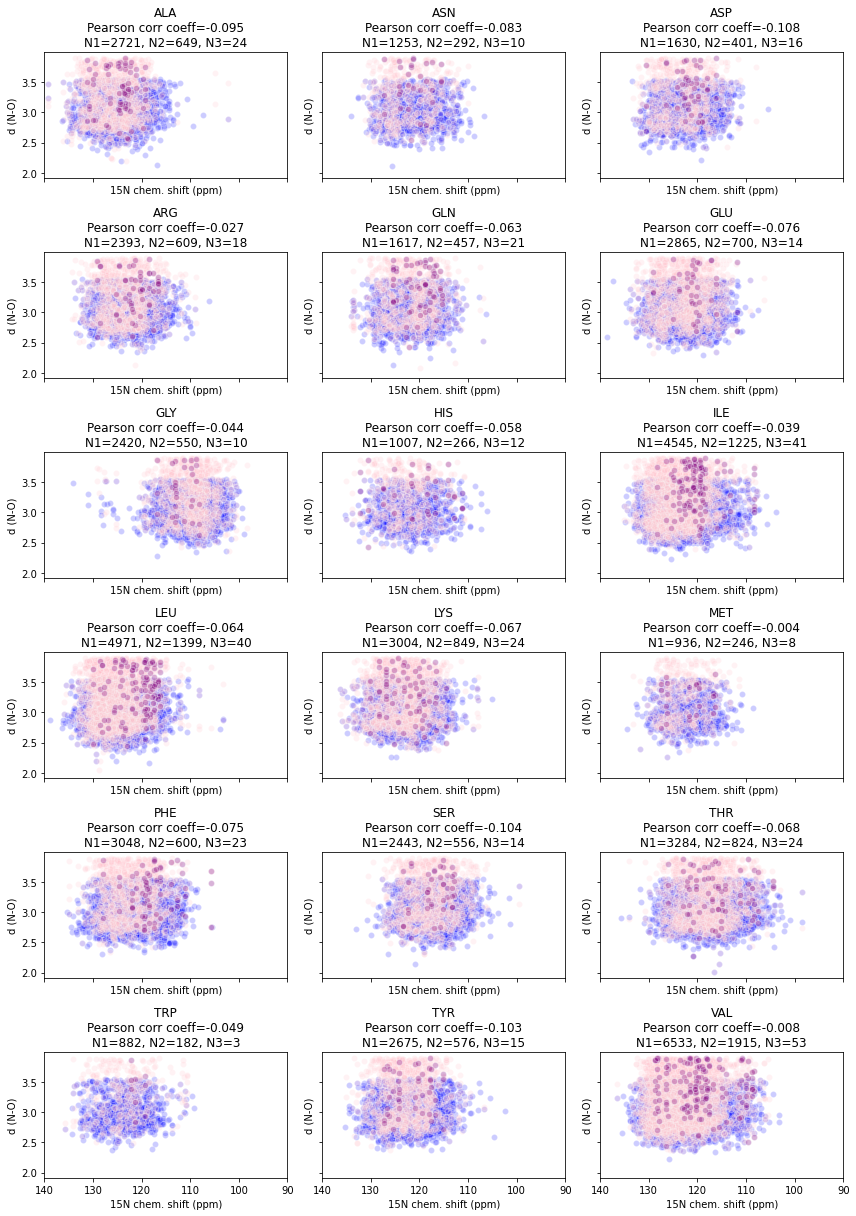

In [54]:
#handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
#                                 lw=0, alpha=0)] * 2

groups1 = df_first_bond[['Shift', 'RES_type', 'H_bond_1_len']].dropna().groupby(by='RES_type')
groups2 = df_second_bond[['Shift', 'RES_type', 'H_bond_1_len', 'H_bond_2_len']].dropna().groupby(by='RES_type')
groups3 = df_third_bond[['Shift', 'RES_type', 'H_bond_1_len', 'H_bond_2_len', 'H_bond_3_len']].dropna().groupby(by='RES_type')
groups4 = df_fourth_bond[['Shift', 'RES_type','H_bond_1_len',  'H_bond_2_len', 'H_bond_3_len', 'H_bond_4_len']].groupby(by='RES_type')

res_list = ['ALA', 'ASN', 'ASP', 'ARG', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 
            'LEU', 'LYS', 'MET', 'PHE', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(12,17), sharex=True, sharey=True)

for res, ax in zip(res_list, axs.ravel()):
    df_1 = groups1.get_group(res)
    pears=np.round(df_1[['Shift', 'H_bond_1_len']].corr().iloc[0,1], 3)
    ax.scatter(df_1.Shift, df_1.H_bond_1_len, alpha=0.2, c='b', edgecolors='white')
    try:
        df_2 = groups2.get_group(res)
        ax.scatter(df_2.Shift, df_2.H_bond_2_len, alpha=0.2, c='pink', edgecolors='white')
        ax.scatter(df_2.Shift, df_2.H_bond_1_len, alpha=0.2, c='pink', edgecolors='white')
    except KeyError:
        pass
    try:
        df_3 = groups3.get_group(res)
        ax.scatter(df_3.Shift, df_3.H_bond_3_len, alpha=0.3, c='purple', edgecolors='white')    
        ax.scatter(df_3.Shift, df_3.H_bond_2_len, alpha=0.3, c='purple', edgecolors='white')    
        ax.scatter(df_3.Shift, df_3.H_bond_1_len, alpha=0.3, c='purple', edgecolors='white')    

    except KeyError:
        pass
    """try:
        df_4 = groups4.get_group(res)
        ax.scatter(df_4.Shift, df_4.H_bond_4_len, alpha=0.3, c='red', edgecolors='white')
    except KeyError:
        pass"""
    
    ax.set_title(res+"\n"+f"Pearson corr coeff={pears}\nN1={len(df_1)}, N2={len(df_2)}, N3={len(df_3)}")
    #for d in [df_2, df_3, df_4]:
    #    d=pd.wide_to_long(d.reset_index().drop_duplicates(), stubnames='H_bond_', i='id', j='Bond')
    #labels = []
    #labels.append(f'N={len(df_plot.dropna())}')
    #ax.legend(handles, labels, loc='best', fontsize='large', 
    #      fancybox=True, framealpha=0.7, 
    #      handlelength=0, handletextpad=0)
    
    ax.set_xlim(140, 90)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
fig.tight_layout()
fig.savefig(f'D://H_bonds//Summary_chem_shift_15N-dist_to_O.jpeg', dpi=200)

## Plot v. 1.2 
Same, bonds ordered

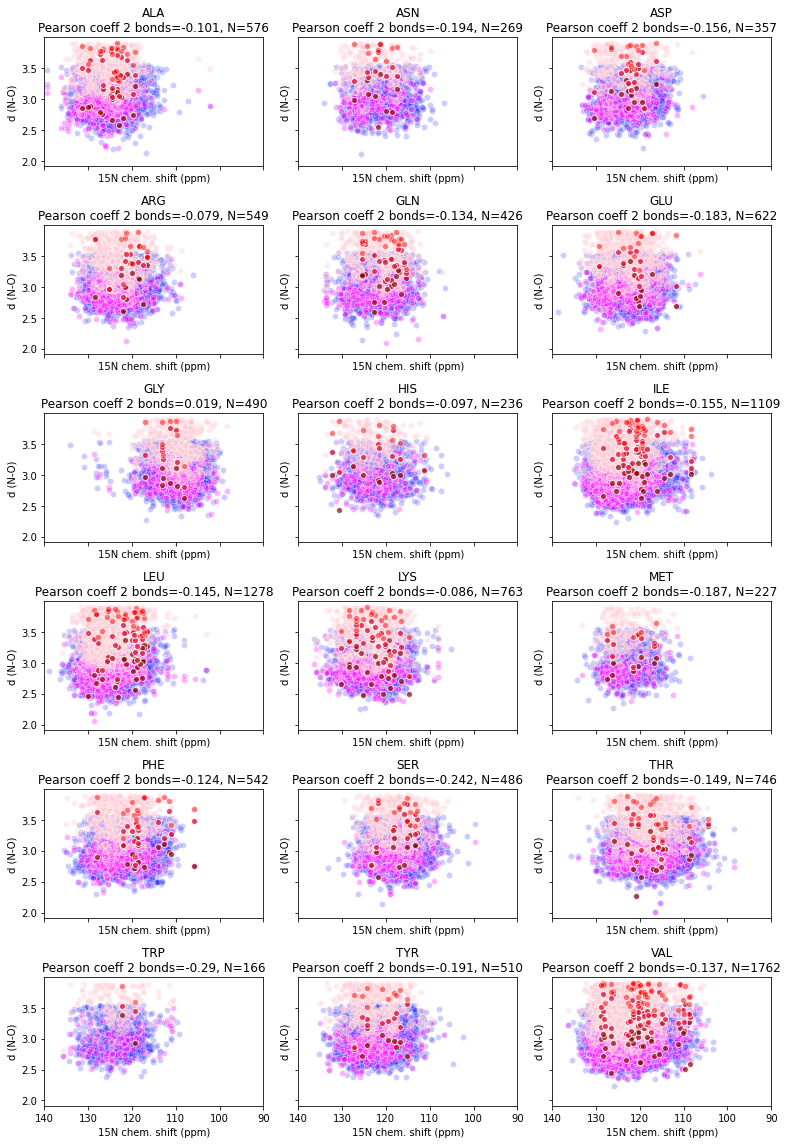

In [208]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

df_2bonds = df_second_bond.loc[df_second_bond.DSSP=='E'].copy()
df_2bonds['H_bond_sh'] = df_2bonds[["H_bond_2_len", "H_bond_1_len"]].min(axis=1)
df_2bonds['H_bond_long'] = df_2bonds[["H_bond_2_len", "H_bond_1_len"]].max(axis=1)


df_3bonds = df_third_bond.loc[df_third_bond.DSSP=='E'].copy()
df_3bonds['H_bond_sh'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].min(axis=1)
df_3bonds['H_bond_mid'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].T.apply(middle)
df_3bonds['H_bond_long'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].max(axis=1)

g2 = df_2bonds[['Shift', 'RES_type', 'H_bond_sh', 'H_bond_long']].dropna().groupby('RES_type')
g3 = df_3bonds[['Shift', 'RES_type', 'H_bond_sh', 'H_bond_mid', 'H_bond_long']].dropna().groupby('RES_type')

for res, ax in zip(res_list, axs.ravel()):
    df_1 = groups1.get_group(res)
    pears=np.round(df_1[['Shift', 'H_bond_1_len']].corr().iloc[0,1], 3)
    ax.scatter(df_1.Shift, df_1.H_bond_1_len, alpha=0.2, c='b', edgecolors='white')
    
    df_2 = g2.get_group(res)
    pears=np.round(df_2[['Shift', 'H_bond_sh']].corr().iloc[0,1], 3)

    ax.scatter(df_2.Shift, df_2.H_bond_sh, c='magenta', alpha=0.3, edgecolors='white')
    ax.scatter(df_2.Shift, df_2.H_bond_long, c='pink', alpha=0.3, edgecolors='white')

    df_3 = g3.get_group(res)
    ax.scatter(df_3.Shift, df_3.H_bond_sh, c='darkred', alpha=0.7, edgecolors='white')
    ax.scatter(df_3.Shift, df_3.H_bond_mid, c='crimson', alpha=0.8, edgecolors='white')
    ax.scatter(df_3.Shift, df_3.H_bond_long, c='red', alpha=0.5, edgecolors='white')

    
    ax.set_title(res+"\n"+f"Pearson coeff 2 bonds={pears}, N={len(df_2)}")
    ax.set_xlim(140, 90)
    #ax.set_ylim(2.0, 3.51)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig(f'D://H_bonds//Summary_chem_shift_15N-dist_to_O_1-2-3bonds.jpeg', dpi=200)

## Plot v. 2.0 

Pearson v.2.0 - only short bonds considered!
No garbage! (Mismatching residue types)

In [5]:
rc_shifts = pd.read_csv('./rc_shifts.tab', sep='\t',
                        header=0, index_col=None)
rc_shifts.RES = rc_shifts.RES.apply(lambda s: s.upper()) 
rc_shifts.set_index('RES', inplace=True)
rc_shifts

ID    CA    CB      N    HN
RES                            
ALA  A  52.5  19.0  123.8  8.15
CYS  C  58.8  28.6  118.8  8.23
ASP  D  54.1  40.8  120.4  8.37
GLU  E  56.7  29.7  120.2  8.36
PHE  F  57.9  39.3  120.3  8.30
GLY  G  45.0     -  108.8  8.29
HIS  H  55.8  32.0  118.2  8.28
ILE  I  62.6  37.5  119.9  8.21
LYS  K  56.7  32.3  120.4  8.25
LEU  L  55.7  41.9  121.8  8.23
MET  M  56.6  32.8  119.6  8.29
ASN  N  53.6  39.0  118.7  8.38
PRO  P  62.9  31.7  135.8     -
GLN  Q  56.2  30.1  119.8  8.27
ARG  R  56.3  30.3  120.5  8.27
SER  S  58.3  62.7  115.7  8.31
THR  T  63.1  68.1  113.6  8.24
VAL  V  63.0  31.7  119.2  8.19
TRP  W  57.8  28.3  121.3  8.18
TYR  Y  58.6  38.7  120.3  8.28

In [6]:
def middle(arr3):
    a,b,c = arr3
    if a==max(a, b, c):
        return max(b,c)
    elif b==max(a, b, c):
        return max(a,c)
    else:
        return max(a,b)

<BarContainer object of 18 artists>

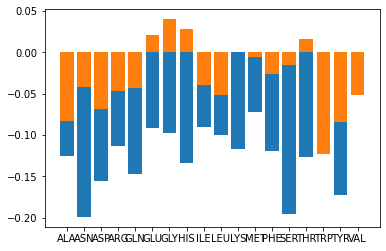

In [80]:
group=amides_N_H_bonds.groupby(by='RES_type')
res_list = ['ALA', 'ASN', 'ASP', 'ARG', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 
            'LEU', 'LYS', 'MET', 'PHE', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

res='ALA'
all_bonds_corr = []
short_bonds_corr = []
Ns = []
for res in res_list:
    df=group.get_group(res)
    idx_pass=df.drop(df.columns[12:], axis=1).where(df['R_type'] == rc_shifts.loc[res, 'ID']).dropna().index
    df = df.loc[idx_pass]
    df['H_Shortest'] = df[['H_bond_1_len','H_bond_2_len','H_bond_3_len','H_bond_4_len']].apply(min, axis=1)
    pears = np.round(df[['H_Shortest', 'Shift']].corr().iloc[0,1], 3)
    pears1 = np.round(df[['Shift', 'H_Shortest']].loc[df['H_Shortest'] < 2.99].corr().iloc[0,1], 3)

    all_bonds_corr.append(pears)
    short_bonds_corr.append(pears1)
    Ns.append(len(df))
    
plt.bar(res_list, all_bonds_corr)
plt.bar(res_list, short_bonds_corr)

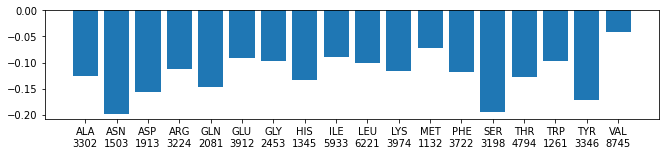

In [66]:
fig = plt.figure(figsize=(11,2))
ax = fig.add_subplot(111)
ax.bar(res_list, all_bonds_corr)
labels = [r+'\n'+str(n) for r, n in zip(res_list, Ns)]
ticks=[x for x in range(0,18,1)]
plt.xticks(ticks, labels)
plt.show()
fig.savefig(f'D://H_bonds//pearson_all_shortest.jpeg', dpi=200)

In [52]:
df_N_H_bonds

Empty DataFrame
Columns: []
Index: []

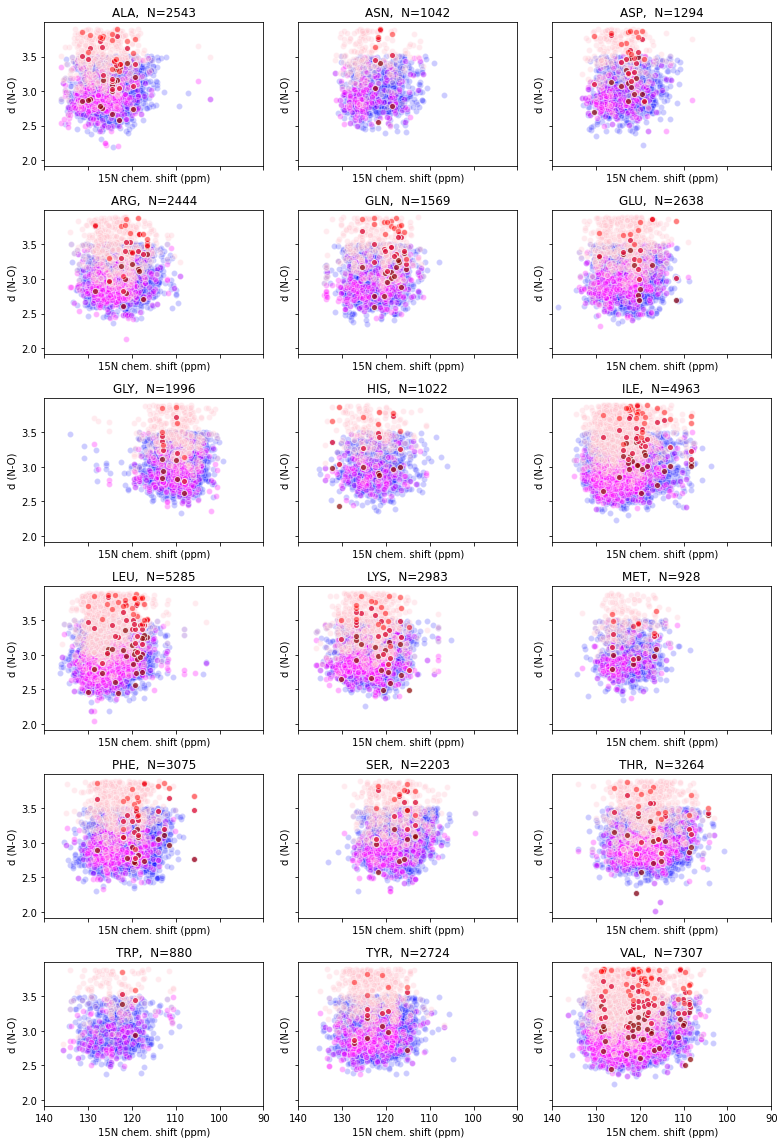

In [57]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

df_N_H_bonds=pd.DataFrame()
#amides_N_H_bonds.copy()
for res in res_list:
    df=group.get_group(res)
    idx_pass=df.drop(df.columns[12:], axis=1).where(df['R_type'] == rc_shifts.loc[res, 'ID']).dropna().index
    df = df.loc[idx_pass]
    df['H_Shortest'] = df[['H_bond_1_len','H_bond_2_len','H_bond_3_len','H_bond_4_len']].apply(min, axis=1)
    df['PearsAllShortest'] = np.round(df[['H_Shortest', 'Shift']].corr().iloc[0,1], 3)
    df['PearsAllShortest'] = np.round(df[['H_Shortest', 'Shift']].corr().iloc[0,1], 3)
    df_N_H_bonds = pd.concat((df_N_H_bonds, df))

#df_fourth_bond = df_N_H_bonds[~ df_N_H_bonds.H_bond_partner_4.isna()].loc[df_N_H_bonds.H_bond_4_len < 3.51]
df_third_bond = df_N_H_bonds[~ df_N_H_bonds.H_bond_partner_3.isna()].loc[df_N_H_bonds.H_bond_3_len < 3.51]
df_second_bond = df_N_H_bonds[~ df_N_H_bonds.H_bond_partner_2.isna()].loc[df_N_H_bonds.H_bond_2_len < 3.51]
df_first_bond = df_N_H_bonds[~ df_N_H_bonds.H_bond_partner_1.isna()].loc[df_N_H_bonds.H_bond_1_len < 3.51]

groups1 = df_first_bond[['Shift', 'RES_type', 'H_bond_1_len']].dropna().groupby(by='RES_type')
groups2 = df_second_bond[['Shift', 'RES_type', 'H_bond_1_len', 'H_bond_2_len']].dropna().groupby(by='RES_type')
groups3 = df_third_bond[['Shift', 'RES_type', 'H_bond_1_len', 'H_bond_2_len', 'H_bond_3_len']].dropna().groupby(by='RES_type')
#groups4 = df_fourth_bond[['Shift', 'RES_type','H_bond_1_len',  'H_bond_2_len', 'H_bond_3_len', 'H_bond_4_len']].groupby(by='RES_type')

df_2bonds = df_second_bond.loc[df_second_bond.DSSP=='E'].copy()
df_2bonds['H_bond_sh'] = df_2bonds[["H_bond_2_len", "H_bond_1_len"]].min(axis=1)
df_2bonds['H_bond_long'] = df_2bonds[["H_bond_2_len", "H_bond_1_len"]].max(axis=1)

df_3bonds = df_third_bond.loc[df_third_bond.DSSP=='E'].copy()
df_3bonds['H_bond_sh'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].min(axis=1)
df_3bonds['H_bond_mid'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].T.apply(middle)
df_3bonds['H_bond_long'] = df_3bonds[["H_bond_3_len", "H_bond_2_len", "H_bond_1_len"]].max(axis=1)

g2 = df_2bonds[['Shift', 'RES_type', 'H_bond_sh', 'H_bond_long']].dropna().groupby('RES_type')
g3 = df_3bonds[['Shift', 'RES_type', 'H_bond_sh', 'H_bond_mid', 'H_bond_long']].dropna().groupby('RES_type')

for res, ax in zip(res_list, axs.ravel()):
    df_1 = groups1.get_group(res)
    pears=np.round(df_1[['Shift', 'H_bond_1_len']].corr().iloc[0,1], 3)
    ax.scatter(df_1.Shift, df_1.H_bond_1_len, alpha=0.2, c='b', edgecolors='white')
    
    df_2 = g2.get_group(res)
    pears=np.round(df_2[['Shift', 'H_bond_sh']].corr().iloc[0,1], 3)

    ax.scatter(df_2.Shift, df_2.H_bond_sh, c='magenta', alpha=0.3, edgecolors='white')
    ax.scatter(df_2.Shift, df_2.H_bond_long, c='pink', alpha=0.3, edgecolors='white')

    df_3 = g3.get_group(res)
    ax.scatter(df_3.Shift, df_3.H_bond_sh, c='darkred', alpha=0.7, edgecolors='white')
    ax.scatter(df_3.Shift, df_3.H_bond_mid, c='crimson', alpha=0.8, edgecolors='white')
    ax.scatter(df_3.Shift, df_3.H_bond_long, c='red', alpha=0.5, edgecolors='white')

    
    ax.set_title(res+f",  N={len(df_1)+len(df_2)+len(df_3)}")
    ax.set_xlim(140, 90)
    #ax.set_ylim(2.0, 3.51)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig(f'D://H_bonds//Summary_chem_shift_15N-dist_to_O_1-2-3bonds_CleanTitle.jpeg', dpi=200)